In [2]:
#please enter the directory where the data report and graphs are to be stored below:
###script creates a folder for the organisation, subfolder for participant and subfolder for kit number

directory="C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)"

#### directory may need / instead of \ in the path

In [28]:
import pandas as pd
import numpy as np
import os
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import boto3
import json
import boto3.session
# https://boto3.amazonaws.com/v1/documentation/api/latest/guide/dynamodb.html#querying-and-scanning
from boto3.dynamodb.conditions import GreaterThan, Key, Attr
import dynamo_pandas
from dynamo_pandas import get_df, keys, put_df
import datetime
from datetime import timedelta
import seaborn as sns
from docx import Document
from docx.shared import Mm
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.table import WD_ALIGN_VERTICAL
from docx.enum.text import WD_BREAK
#from docx.enum.table import WD_ALIGN_HORIZONTAL
from docx2pdf import convert

def connect_dynamodb(region = 'eu-west-2', profile = 'default'):
    # Connect to DynamoDB
    my_session = boto3.session.Session(region_name = region, profile_name = profile)
    global dynamodb
    dynamodb = my_session.resource('dynamodb')

connect_dynamodb('eu-west-2','default')

#define tables
table_athlete = dynamodb.Table('Athlete-qx7lirnxjfdzxoss6cmomxzgpe-staging')
table_sample = dynamodb.Table('Sample-qx7lirnxjfdzxoss6cmomxzgpe-staging')
table_measurement = dynamodb.Table('Measurement-qx7lirnxjfdzxoss6cmomxzgpe-staging')
table_study = dynamodb.Table('Study-qx7lirnxjfdzxoss6cmomxzgpe-staging')
table_testbatchcode = dynamodb.Table('TestBatchCode-qx7lirnxjfdzxoss6cmomxzgpe-staging')
table_answer = dynamodb.Table('Answer-qx7lirnxjfdzxoss6cmomxzgpe-staging')
table_organisation = dynamodb.Table('Organisation-qx7lirnxjfdzxoss6cmomxzgpe-staging')

def get_org_from_dynamo(table):

    org_df_meta=dynamo_pandas.get_df(table=table)

    inTitles = False
    while inTitles == False:
        
        org = input('Enter name of organisation: ')
            # Is prog in response?
    #         print(len(prog_df[prog_df.title == prog]))
        if len(org_df_meta[org_df_meta.name == org]) == 1:
            
            inTitles = True
            org_df = org_df_meta[org_df_meta.name == org] 

        else:
            inTitles=False
            print('Organisation not found. Please try again and ensure it is typed correctly')
            
                
    print('Organisation Name: ' + str(org_df['name'].values[0]))      
        
    org_code = org_df['code'].values[0]
    org_code_GCR = org_df['groupCanRead'].values[0]
    print('Organisation code:', org_code)

    return org_code_GCR

#get programme from org

def get_prog_from_org(org_code_GCR):  
    
    prog_df_meta=dynamo_pandas.get_df(table='Study-qx7lirnxjfdzxoss6cmomxzgpe-staging')

    prog_df_org=prog_df_meta[prog_df_meta['groupCanRead']==org_code_GCR]

    if len(prog_df_org)==0:
        print('No programmes found for this organisation')
    elif len(prog_df_org)==1:
        prog=prog_df_org['title'].values[0]
        print('This organisation has one programme:', prog)
        prog_df=prog_df_org[prog_df_org['title']==prog]
    else:
        print('Please input programme from this list: ')
        print(prog_df_org['title'])
        
        inTitles = False
        while inTitles == False:
            prog = input('Enter title of programme: ')
            
            if len(prog_df_org[prog_df_org.title == prog]) == 1:
                inTitles = True
                prog_df = prog_df_org[prog_df_org.title == prog] 
            else:
                print('Programme name not found. Please try again and ensure it is typed correctly')

    print('Programme title: ' + str(prog_df['title'].values[0]))      
        
    programme_id = prog_df['id'].values[0]
    print('Programme ID:', programme_id)
    return programme_id

#Get participants
def get_participants_from_study(programme_id, org_code_GCR):

    par_df_meta=dynamo_pandas.get_df(table='Athlete-qx7lirnxjfdzxoss6cmomxzgpe-staging')
    par_df_prog=par_df_meta[par_df_meta['athleteStudyId']==programme_id]
    par_id_l=[]


    if len(par_df_prog)==0:
        print('No participants found for this programme')
    elif len(par_df_prog)==1:
        par=par_df_prog['name'].values[0]
        par_df=par_df_prog[par_df_prog['name']==par]
        par_id = par_df['id'].values[0]
        par_id_l.append(par_id)
        print('This study has one participant:', par)
    else:
        print('This programme has', len(par_df_prog), 'participants')
        print('Please input participant name from this list | or type ALL to generate batch report: ')
        print(par_df_prog['name'])
        inTitles = False
        while inTitles == False:
            par = input('Enter name of participant, or enter ALL for batch report: ')
            
            if len(par_df_prog[par_df_prog.name == par]) == 1:
                inTitles = True
                par_df = par_df_prog[par_df_prog.name == par]
                print('Participant Name: ' + str(par_df['name'].values[0]))  
                par_id = par_df['id'].values[0]
                par_id_l.append(par_id)
                print('Participant ID:', par_id)
                
            elif (par=='ALL')|(par=='all')|(par=='All'):
                par_df=par_df_prog
                par_id_l=list(par_df['id'])
                inTitles = True
                print('Generating batch report for entire programme...')
            else:
                print('Participant not found. Please try again and ensure their name is typed correctly')

    
    return par_id_l

def get_participants_from_org(org_code_GCR):

    par_df_meta=dynamo_pandas.get_df(table='Athlete-qx7lirnxjfdzxoss6cmomxzgpe-staging')
    par_id_l=[]
    

    org_code=org_code_GCR[:-4]
    orgAdmin= org_code+'Admin'

    par_df_org=par_df_meta.loc[par_df_meta['groupCanAdmin']==orgAdmin]
    
    #print(len(par_df_org_id_list), len(par_df_prog_id_list))

    if len(par_df_org)==0:
        print('No participants found for this programme')
    elif len(par_df_org)==1:
        par=par_df_org['name'].values[0]
        par_df=par_df_org[par_df_org['name']==par]
        par_id= par_df['id'].values[0]
        par_id_l.append(par_id)
        print('This organisation has one participant:', par)
    else:
        print('This organisation has', len(par_df_org), 'participants')
        print('Please input participant name from this list | or type ALL to generate batch report: ')
        print(par_df_org['name'])
        inTitles = False
        while inTitles == False:
            par = input('Enter name of participant, or enter ALL for batch report: ')
            
            if len(par_df_org[par_df_org.name == par]) == 1:
                inTitles = True
                par_df = par_df_org[par_df_org.name == par]
                print('Participant Name: ' + str(par_df['name'].values[0]))  
                
                par_id = par_df['id'].values[0]
                par_id_l.append(par_id)
                print('Participant ID:', par_id)
                
            elif (par=='ALL')|(par=='all')|(par=='All'):
                par_df=par_df_org
                par_id_l=list(par_df['id'])
                inTitles = True
                print('Generating batch report for entire organisation...')
            else:
                print('Participant not found. Please try again and ensure their name is typed correctly')

    
    return par_id_l


def get_test_batch_codes(table1):
    #Fetch test batch code ids for estradiol and progesterone
    tbc_df_meta=dynamo_pandas.get_df(table=table1)
    #tbc_df_meta_p = tbc_df_meta[tbc_df_meta['participantId']==par]
    
    estradiol_tbc_l=list(tbc_df_meta.loc[(tbc_df_meta['name']=='PTP_ELISA_IBL_ESTRADIOL') | (tbc_df_meta['name']=='ELISA_IBL_ESTRADIOL'), 'id'])
    progesterone_tbc_l=list(tbc_df_meta.loc[(tbc_df_meta['name']=='PTP_ELISA_IBL_PROGESTERONE') | (tbc_df_meta['name']=='ELISA_IBL_PROGESTERONE'), 'id'])

    #estradiol_tbc_id = tbc_df_meta.loc[tbc_df_meta['name']=='ELISA_IBL_ESTRADIOL', 'id'].iloc[0] 
    #progesterone_tbc_id = tbc_df_meta.loc[tbc_df_meta['name']=='ELISA_IBL_PROGESTERONE', 'id'].iloc[0] 

    return estradiol_tbc_l, progesterone_tbc_l



def scan_table(dynamoTable, filterExp, expAttrNames):
    
    
    results = []
    projExp = ''
    fExp = ''
    
    # Construct ProjectionExpression string
    for key, value in expAttrNames.items() :
        if projExp == '':
            projExp = key
        else:
            projExp = projExp + ', ' + key 
        
    # Construct FilterExpression string
    for key, value in filterExp.items() :
        if fExp == '':
            fExp = 'Attr(\'{}\').eq(\'{}\')'.format(key,value)
        else:
            fExp = fExp + ' & Attr(\'{}\').eq(\'{}\')'.format(key,value) 
    
    
    response = dynamoTable.scan(
        ProjectionExpression=projExp,
        FilterExpression = eval(fExp),
        ExpressionAttributeNames = expAttrNames # Need to use ExpressionAttributeNames as some field names are reserved keywords (e.g. value)
    )
    results = response['Items']
    
    # Get all items (https://dynobase.dev/dynamodb-python-with-boto3/#scan)
    while 'LastEvaluatedKey' in response:
        response = dynamoTable.scan(ExclusiveStartKey = response['LastEvaluatedKey'],
                                    ProjectionExpression=projExp,
                                    FilterExpression = eval(fExp),
                                    ExpressionAttributeNames = expAttrNames # Need to use ExpressionAttributeNames as value is a reserved keyword
                                          )
        results.extend(response['Items'])

    return results

def getmostrecentkit(par):
    kit_measurements = scan_table(table_measurement,
                                    filterExp = {'measurementAthleteId' : par, 
                                    'measurementTestBatchCodeId' : estradiol_tbc_id},
                                    expAttrNames = {'#i' : 'id', '#b' : 'barcode',
                                                    '#m' : 'measurementAthleteId' , 
                                                    '#v' : 'value', 
                                                    '#k' : 'kit', 
                                                    '#c' : 'collectedAt', 
                                                    '#t':'measurementTestBatchCodeId'})


        

    measurement_df = pd.DataFrame.from_dict(kit_measurements)
    if len(measurement_df)==0:
        print('No hormone measurements found for this participant')
    else:
    
        mostrecentkit=[]


        kitlist=measurement_df.loc[measurement_df['measurementAthleteId']==par, 'kit'].unique()
        print('Finding most recent kit...')
        if len(kitlist)>0:
            kitnums = [kit[3:] for kit in kitlist]
            maxkit=max(kitnums)
            df_par_kit=measurement_df[(measurement_df['measurementAthleteId']==par) & (measurement_df['kit']=='KIT'+maxkit)]
            
            #print(len(df_par_kit))
            mostrecentkit.append(df_par_kit)
        if len(mostrecentkit)==0:
            print('No kits found for this participant ID:', par)
        else:

            df_mostrecentkit=pd.concat(mostrecentkit)

            return df_mostrecentkit

def getallkitnums(par):
    kit_measurements = scan_table(table_measurement,
                                    filterExp = {'measurementAthleteId' : par},
                                    expAttrNames = {'#i' : 'id', '#b' : 'barcode',
                                                    '#m' : 'measurementAthleteId' , 
                                                    '#v' : 'value', 
                                                    '#k' : 'kit', 
                                                    '#c' : 'collectedAt', 
                                                    '#t':'measurementTestBatchCodeId'})


        

    measurement_df = pd.DataFrame.from_dict(kit_measurements)
    if len(measurement_df)==0:
        print('No hormone measurements found for this participant')
        kitlist=[]
        return kitlist
    else:
        kitlist=measurement_df.loc[measurement_df['measurementAthleteId']==par, 'kit'].unique()
        kitnums = [kit[3:] for kit in kitlist]
        print('Found kits:', kitnums)
    
        
        return kitlist

#---------------------------------------------------------

def get_e_df_and_p_df(kitnum, par, estradiol_tbc_id_l, progesterone_tbc_id_l):

    estradiol_measurements = scan_table(table_measurement,
                                    filterExp = {'measurementAthleteId' : par,
                                                'kit' : kitnum},
                                    expAttrNames = {'#i' : 'id', 
                                                    '#b' : 'barcode' , 
                                                    '#v' : 'value', 
                                                    '#k' : 'kit', 
                                                    '#c' : 'collectedAt',
                                                    '#t':'measurementTestBatchCodeId'})

    
        
# print(estradiol_measurements)
    estradiol_df = pd.DataFrame.from_dict(estradiol_measurements)

    estradiol_df = estradiol_df.loc[estradiol_df['measurementTestBatchCodeId'].isin(estradiol_tbc_id_l)]
    #print(estradiol_tbc_id)
    #estradiol_df = estradiol_df.loc[estradiol_df['measurementTestBatchCodeId']==estradiol_tbc_id]

    print('Number of estradiol measurements retrieved: {}'.format(len(estradiol_df)))
    
    if len(estradiol_df)>0:
        estradiol_df = estradiol_df.rename(columns = {"value" : "edata"})
        estradiol_df['collectedAt'] = pd.to_datetime(estradiol_df['collectedAt'])
        estradiol_df['collectedDate'] = pd.to_datetime(estradiol_df['collectedAt']).dt.date    
        estradiol_df = estradiol_df.sort_values(by=['collectedAt'], ascending = True, ignore_index = True).drop(columns = ['collectedAt'])
        #estradiol_df.loc[estradiol_df['edata'].str.contains('<'), 'edata'] = estradiol_df['edata'].str.replace('<','')
        #estradiol_df.loc[estradiol_df['edata'].str.contains('>'), 'edata'] = estradiol_df['edata'].str.replace('>','')
        estradiol_df['edata_r'] = estradiol_df['edata']
        estradiol_df.loc[estradiol_df['edata'].str.contains('<', na=False), 'edata'] = np.nan
        estradiol_df.loc[estradiol_df['edata'].str.contains('>', na=False), 'edata'] = np.nan

            
        estradiol_df['edata'] = estradiol_df['edata'].astype(float)
        #estradiol_df['edata_r'] = estradiol_df['edata_r'].astype(float)
        
        estradiol_df['linear'] = estradiol_df['edata'].interpolate(method='linear')
        e_df = estradiol_df
        e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'])
        e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y')) 
        print(e_df['collectedDate'].min(), e_df['collectedDate'].max())
        e_df = e_df.set_index('collectedDate')
        e_df= e_df.loc[~e_df.index.duplicated(), :]
        e_df = e_df.resample('1D').asfreq()
        e_df['linear'] = e_df['edata'].interpolate(method='linear')
        e_df = e_df.drop(columns = ['barcode','id','kit'])

        
        # Calculate rolling average with a window
        window = 3
        e_df['rolling'] = e_df['linear'].rolling(window).sum()/window
        e_df['rolling'] = e_df['rolling'].shift(periods = -1)
        #e_df.loc[e_df['edata_r'].str.contains('<', na=False), 'rolling'] = np.nan
        #e_df.loc[e_df['edata_r'].str.contains('>', na=False), 'rolling'] = np.nan
        e_df_n=e_df['edata'].dropna()

        n_max=e_df_n.index.max()

        e_df.loc[e_df.index>n_max, 'rolling'] = np.nan

        e_df.head()

    progesterone_measurements = scan_table(table_measurement,
                                    filterExp = {'measurementAthleteId' : par,
                                                'kit' : kitnum},
                                    expAttrNames = {'#i' : 'id', 
                                                    '#b' : 'barcode' , 
                                                    '#v' : 'value', 
                                                    '#k' : 'kit', 
                                                    '#c' : 'collectedAt',
                                                    '#t':'measurementTestBatchCodeId'})

    
            
    # print(estradiol_measurements)
    progesterone_df = pd.DataFrame.from_dict(progesterone_measurements)
    progesterone_df = progesterone_df.loc[progesterone_df['measurementTestBatchCodeId'].isin(progesterone_tbc_id_l)]
    
    #progesterone_df=progesterone_df.loc[progesterone_df['measurementTestBatchCodeId']==progesterone_tbc_id]

    
    print('Number of progesterone measurements retrieved: {}'.format(len(progesterone_df)))
    if len(progesterone_df)>0:
        progesterone_df = progesterone_df.rename(columns = {"value" : "pdata"})
        progesterone_df['collectedAt'] = pd.to_datetime(progesterone_df['collectedAt'])
        progesterone_df['collectedDate'] = pd.to_datetime(progesterone_df['collectedAt']).dt.date    
        progesterone_df = progesterone_df.sort_values(by=['collectedAt'], ascending = True, ignore_index = True).drop(columns = ['collectedAt'])
        #progesterone_df.loc[progesterone_df['pdata'].str.contains('<'), 'pdata'] = progesterone_df['pdata'].str.replace('<','')
        #progesterone_df.loc[progesterone_df['pdata'].str.contains('>'), 'pdata'] = progesterone_df['pdata'].str.replace('>','')
        progesterone_df['pdata_r'] = progesterone_df['pdata']
        progesterone_df.loc[progesterone_df['pdata'].str.contains('<'), 'pdata'] = np.nan
        progesterone_df.loc[progesterone_df['pdata'].str.contains('>'), 'pdata'] = np.nan
        
        progesterone_df['pdata'] = progesterone_df['pdata'].astype(float)
        #progesterone_df['pdata_r'] = progesterone_df['pdata_r'].astype(float)
        
        progesterone_df['linear'] = progesterone_df['pdata'].interpolate(method='linear')
        p_df = progesterone_df
        p_df['collectedDate'] = pd.to_datetime(p_df['collectedDate'])
        p_df = p_df.set_index('collectedDate')
        p_df= p_df.loc[~p_df.index.duplicated(), :]
        p_df = p_df.resample('1D').asfreq()
        p_df['linear'] = p_df['pdata'].interpolate(method='linear')
        p_df = p_df.drop(columns = ['barcode','id','kit'])
        window = 3
        p_df['rolling'] = p_df['linear'].rolling(window).sum()/window
        p_df['rolling'] = p_df['rolling'].shift(periods = -1)
        p_df.loc[p_df['pdata_r'].str.contains('<', na=False), 'rolling'] = np.nan
        p_df.loc[p_df['pdata_r'].str.contains('>', na=False), 'rolling'] = np.nan
        p_df.head()
    
        return e_df, p_df 
    #-----------------------------------------------------------------------------------------------------------------------
def get_samples(par, kitnum):
    samples = scan_table(dynamoTable = table_sample,
                    #  filterExp = {'sampleAthleteId' : athlete_id},
                    filterExp = {'sampleAthleteId' : par,
                                'kit' : kitnum},
                    expAttrNames = {'#b' : 'barcode', '#c' : 'collectedAt'})

    print('Number of samples retrieved: {}'.format(len(samples)))
    # print(samples)
    samples_df = pd.DataFrame.from_dict(samples)
    samples_df['collectedAt'] = pd.to_datetime(samples_df['collectedAt'])
    samples_df['collectedDate'] = pd.to_datetime(samples_df['collectedAt']).dt.date
    samples_df['collectedTime'] = pd.to_datetime(samples_df['collectedAt']).dt.time
    samples_df = samples_df.sort_values(by=['collectedAt'], ascending = True, ignore_index = True).drop(columns = ['collectedAt'])
    return samples_df
#-----------------------------------------------------------------------------------------------------------------------
def get_answers(par, kitnum):
    answers = scan_table(dynamoTable = table_answer,
                            filterExp = {'athleteID' : par, 
                                                'kit' : kitnum},
                            expAttrNames = {'#v' : 'value', '#c' : 'collectedAt'})
        
    answers_df = pd.DataFrame.from_dict(answers)
    if len(answers_df)==0:
        print('No answers data found')
    #get_pdf_no_symptoms(samples_df, e_df, p_df, par, export_path)
    else:
        #answers = dynamo_pandas.get_df(table='Answer-qx7lirnxjfdzxoss6cmomxzgpe-staging') 
        #answers_df=answers.loc[(answers['athleteID']==par) & (answers['kit']==kitnum)]
        #answers_df=answers_df.filter(['athleteID','value', 'kit', 'collectedAt'], axis=1)
        #answers_df = answers_df.reset_index()
        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedAt']).dt.date   

    # Initialise Bleeding column
        answers_df['Bleeding'] = 'No'

        # Sort answers by collectedAt date
        answers_df = answers_df.sort_values(by=['collectedAt'], ascending = True, ignore_index = True)

        answers_df['collectedAt'] = pd.to_datetime(answers_df['collectedAt'])
        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedAt']).dt.date
        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate'])

        # Remove all answers after the last date of the samples_df
        # answers_df = answers_df.astype({'collectedDate' : 'datetime64[ns]'}) # Change type
        # print(answers_df['collectedDate'].dtypes)
        # print(samples_df['collectedDate'].dtypes)
        # print(answers_df)
        # print(samples_df['collectedDate'].iloc[-1])
        # answers_df = answers_df[answers_df['collectedDate'] >= samples_df['collectedDate'].iloc[0]]
        # answers_df = answers_df[answers_df['collectedDate'] <= samples_df['collectedDate'].iloc[-1]]
        answers_df = answers_df.reset_index(drop = True)
        #----

        answers_df['Your Sleep'] = np.nan

        symptoms = ['Backache',
                    'Joint pain',
                    'Abdominal pain',
                    'Abdominal cramps',
                    'Breast tenderness',
                    'Headaches',
                    'Heavy legs',
                    'Muscle spasms',
                    'Clumsiness',
                    'Gastrointestinal upset',
                    'Food craving',
                    'Binge eating',
                    'Reduced appetite',
                    'Fatigue',
                    'Increased sex drive',
                    'Skin problems',
                    'Common cold symptoms',
                    'Low mood',
                    'Sadness',
                    'Tearful',
                    'Mood swings',
                    'Anxiety',
                    'Paranoia',
                    'Concentration loss',
                    'Confusion']

        # for symptom in symptoms:
        #     answers_df.insert(len(answers_df.columns),
        #                      symptom,
        #                      allow_duplicates=False)

        symptoms_df = pd.DataFrame(0, index=np.arange(len(answers_df)), columns=symptoms)
        # print(symptoms_df)
        answers_df = answers_df.join(symptoms_df)
        answers_df.head()

        
        # Find all days where Bleeding is reported
        for i, row in answers_df.iterrows():
            drow = json.loads(row['value'])         
            for key in drow.keys():
        #         print(drow[key])
                if drow[key]['questionTitle'] == 'Bleeding':
                    if drow[key]['value'] == 'Yes':
                        answers_df.loc[i,'Bleeding'] = 'Yes' # Sets zero when PAR reports bleeding. This is for charting later.
                    
                elif drow[key]['questionTitle'] == 'Your Sleep':
                    answers_df.loc[i, 'Your Sleep'] = drow[key]['value']
                    
                elif drow[key]['questionTitle'] == 'Rate your Symptoms':
        #             print(drow[key]['value'])
                    for item in drow[key]['value']: # Each item in list is a dict with label and value
                        if 'value' in item:
                            answers_df.loc[i, item['label']] = item['value']

        bleedingdays = answers_df[answers_df['Bleeding'] == 'Yes']['collectedDate']
        bleedingdays

    return answers_df  
#---------------------------------------------------------------------------------------------------------------------
def get_figure(answers_df, e_df, p_df, path):
        
    
    from datetime import timedelta
    if len(answers_df)==0:
        print('No bleeding recorded for this participant')
    else:
        bleedingdays = answers_df.loc[answers_df['Bleeding'] == 'Yes','collectedDate']
    #bleedingdays.reset_index()
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex = True, figsize=(10,5))
    ax2 = ax1.twinx()
    e_max=e_df.edata.max()
    
    e_df.loc[e_df['rolling']>e_max, 'rolling']==np.nan


    # Plot objects

    # e_df.reset_index().plot.area(ax = ax1, x='collectedDate', y='rolling', 
    #          color = '#FFC8D344', linewidth = 5)
    # e_df.reset_index().plot(ax = ax1, x='collectedDate', y='rolling', 
    #          color = '#DB2525')
    # p_df.reset_index().plot.area(ax = ax2, x='collectedDate', y='rolling', 
    #          color = '#BAF67F44', linewidth = 5)
    
    e_df.reset_index().plot(ax = ax1, x='collectedDate', y='rolling', 
            color = '#FFC8D3', linewidth=6, label='Oestradiol Average')
    e_df.reset_index().plot(ax = ax1, x='collectedDate', y='edata', 
            color = '#DB2525', marker = 'o', markersize = 6, linestyle = 'none', label = 'Oestradiol')
    p_df.reset_index().plot(ax = ax2, x='collectedDate', y='rolling', 
            color = 'palegreen', linewidth=6, label='Progesterone Average')
    p_df.reset_index().plot(ax = ax2, x='collectedDate', y='pdata', 
            color = 'limegreen', marker = 'o', markersize = 6, linestyle = 'none', label = 'Progesterone')

    #answers_df.reset_index().plot(ax = ax1, x='collectedDate', y = 'Bleeding',
                    #color = '#DB2525', marker = 'o', markersize = 10, linestyle = 'none')

    ylow, yhigh = ax1.get_ylim()
    xlow, xhigh = ax1.get_xlim()
    if len(answers_df)>0:
        if len(bleedingdays)>0:
            for i in range(len(bleedingdays)):


                if i == 0:
                    
                    ax1.text(xlow+((xhigh-xlow)/20)
                    , yhigh-((yhigh-ylow)/20), 
                    'Menses', 
                            color = '#AA0E24', fontsize = 14, fontstyle = 'normal', fontweight = 'bold', horizontalalignment='left')
                        
                ax1.axvline(bleedingdays.iloc[i], linestyle = 'None',color='crimson', marker = 'o',  markersize = 14)
        else:
            print('No bleeding recorded for this participant')

        # Set limits

    ax1.set_xlim(p_df.reset_index()['collectedDate'].min() + timedelta(days = -2), 
                p_df.reset_index()['collectedDate'].max() + timedelta(days = 2))

    # ax1.set_ylim(0, e_df['edata'].max() + 0.5)

    # Time axis formatting
    plt.gcf().autofmt_xdate()
    #set ticks every week
    # ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


    ax1.set_ylabel('Oestradiol, pg/mL', color = '#DB2525', fontsize = 16)
    ax2.set_ylabel('Progesterone, pg/mL', color = 'limegreen', fontsize = 16)
    ax1.set_xlabel('Date of sample collection', fontsize = 16)
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    # plt.grid(True, axis = 'x' )
    ax1.grid(True, which = 'both', axis = 'x', color='#DDDDDD', linestyle='--', linewidth=1 )
    plt.savefig(os.path.join(path,'EPchart.png'), format='png', dpi=1200)
    plt.show()

    return ax1
#---------------------------------------------------------------------------------------------------------------------
def get_symptom_df(answers_df):
    answers_df.loc['total'] = answers_df.sum(numeric_only=True)

    answers_df.loc['rank'] = answers_df.loc['total'].rank(ascending = False)
    #print(answers_df)

    symp_s = answers_df.loc['rank'][answers_df.loc['rank']<10].sort_values(ascending = True)
    symp_df = symp_s.to_frame()
    symp_df['total'] = ''

    for index, row in symp_df.iterrows():
        
        row['total'] = answers_df.loc['total', index]


    #print(len(symp_df))
    print(symp_df)

    return symp_df, len(symp_df)
#---------------------------------------------------------------------------------------------------------------------
def get_symptom_donut(symp_df, path):
    plt.close()
    fig, ax = plt.subplots(figsize=(8,4), subplot_kw=dict(aspect="equal"))
    symp_df['total'] = symp_df['total'].astype(int)
    ax.axis('equal')


    patches, texts = ax.pie(symp_df['total'], colors=['mediumturquoise','#F5BF00','orchid','#43A8FF', 'orange', 'gray', 'limegreen', 'indianred', 'pink'], wedgeprops=dict(width=0.5), startangle=-40)
    #porcent = 100.*symp_df['total']/symp_df['total'].sum()

    labels = symp_df.index
    x=symp_df.index
    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, symp_df['total']),
                                            key=lambda x: x[2],
                                            reverse=True))

    plt.legend(patches, labels, loc='center', bbox_to_anchor=(1, 0.5),
            fontsize=10, frameon=False)
    
    plt.tight_layout()


    #ax.set_title("Matplotlib bakery: A donut")
    plt.savefig(os.path.join(path, 'SymptomDonut_wlegend.png'), format='png', dpi=1200, bbox_inches='tight')
    plt.show()
#---------------------------------------------------------------------------------------------------------------------
def get_symptom_chart (answers_df, symp_df, path):

    bleedingdays = answers_df.loc[answers_df['Bleeding'] == 'Yes','collectedDate']
    symp_col = symp_df.index.tolist()[:4]
    print('Top recorded symptoms are:', symp_col)

    # print(symp_col)
    # Remove total and rank rows from answers_df
    answers_df = answers_df.drop(['total', 'rank'])

    plt.close()

    # answers_df.iloc[:26]['collectedDate']

    fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex = True, figsize=(10,5))
    # # ax.bar(x, y, width=10)
    # # ax.xaxis_date()

    # answers_df.set_index('collectedDate').iloc[:][symp_col].plot(ax = ax1, kind='bar', width = 1, figsize=(8, 4),)
    #answers_df.loc[answers_df[symptom]==0.0, symptom]=np.nan
    answers_df.plot(ax = ax1, 
                    x='collectedDate', 
                    y=symp_col,
    #                 kind = 'bar',
                    color = ['turquoise','#F5BF00','orchid','#43A8FF'],
                    marker = 'o',
                    markersize = 12,
                    linewidth=0)

    # ylow, yhigh = ax1.get_ylim()
    # print('{}, {}'.format(ylow,yhigh))

    ax1.set_ylim([0,10])
    xlow, xhigh = ax1.get_xlim()
    # print(bleedingdays)
    for i in range(len(bleedingdays)):
        if i == 0:
    #         print(type(pd.to_datetime(bleedingdays[i])))
            ax1.text(xlow+((xhigh-xlow)/20), 9, 'Menses', 
                    color = '#AA0E24', fontsize = 14, fontstyle = 'normal', fontweight = 'bold')
        ax1.axvline(bleedingdays.iloc[i], linestyle = 'None', color='crimson', marker = 'o',  markersize = 14)
        
        
    ax1.legend(loc='center left')
    # Time axis formatting
    plt.gcf().autofmt_xdate()
    # #set ticks every week
    # ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
    # #set major ticks format
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    ax1.set_xlabel('Date', fontsize = 16)
    ax1.set_ylabel('Score', fontsize = 16)

    plt.savefig(os.path.join(path, 'SymptomChart_dotplot.png'), format='png', dpi=1200)
    #plt.show()

    return plt
#---------------------------------------------------------------------------------------------------------------------
def combined_chart(answers_df, symp_df, path, e_df, p_df):
    plt.close()
    answers_df = answers_df.dropna(subset=['collectedDate'])
    fig, (ax1,ax3) = plt.subplots(nrows=2, ncols=1, sharex = True, figsize=(10,17))
    ax2 = ax1.twinx()
    answers_df = answers_df.reset_index(drop = True)
    answers_df = answers_df.sort_values(by=['collectedAt'], ascending = True, ignore_index = True)

    bleedingdays = answers_df.loc[answers_df['Bleeding'] == 'Yes','collectedDate']
    #answers_df = answers_df.set_index('collectedDate')

    bleedingdays = answers_df.loc[answers_df['Bleeding'] == 'Yes','collectedDate']
    symp_col = symp_df.index.tolist()[:4]
    #print('Top recorded symptoms are:', symp_col)

    # Plot objects

    e_df.reset_index().plot(ax = ax1, x='collectedDate', y='rolling', 
            color = '#FFC8D3', linewidth=6, label='Oestradiol Average')
    e_df.reset_index().plot(ax = ax1, x='collectedDate', y='edata', 
            color = '#DB2525', marker = 'o', markersize = 6, linestyle = 'none', label = 'Oestradiol')
    p_df.reset_index().plot(ax = ax2, x='collectedDate', y='rolling', 
            color = 'palegreen', linewidth=6, label='Progesterone Average')
    p_df.reset_index().plot(ax = ax2, x='collectedDate', y='pdata', 
            color = 'limegreen', marker = 'o', markersize = 6, linestyle = 'none', label = 'Progesterone')

    legendon = False

    ax1.get_legend().remove()

    if legendon:   
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='center left')
    else:
        ax2.get_legend().remove()

    # answers_df.plot(ax = ax1, x='collectedDate', y = 'Bleeding',
    #                 color = '#DB2525', marker = 'o', markersize = 10, linestyle = 'none')

    ylow, yhigh = ax1.get_ylim()
    xlow, xhigh = ax1.get_xlim()
    #bleedingdays = bleedingdays.loc[(bleedingdays >= xlow) & (bleedingdays <= xhigh)]
    bleedingdays2=bleedingdays.loc[(bleedingdays >= p_df.reset_index().collectedDate.min()) & (bleedingdays <= p_df.reset_index().collectedDate.max())]
    for i in range(len(bleedingdays)):
        if i == 0:
    #         print(type(pd.to_datetime(bleedingdays[i])))
            ax1.text(bleedingdays2.iloc[0],
                     yhigh-((yhigh-ylow)/20), 'Menses', horizontalalignment='left',
        verticalalignment='top', color = '#AA0E24', fontsize = 14, fontstyle = 'normal', fontweight = 'bold')
        ax1.axvline(bleedingdays.iloc[i], linestyle = 'None',color='crimson', marker = 'o',  markersize = 14)

    ax1.set_ylabel('Oestradiol, pg/mL', color = '#DB2525', fontsize = 16)
    ax2.set_ylabel('Progesterone, pg/mL', color = 'limegreen', fontsize = 16)
    ax1.set_xlabel('Date of sample collection', fontsize = 16)

    #ax1.grid(True, which = 'both', axis = 'x', color='#DDDDDD', linestyle='--', linewidth=1 )
    plt.gcf().autofmt_xdate()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    # Symptom chart
    colors=['turquoise','#F5BF00','orchid','#43A8FF']
    dashes=['dashed', 'dotted', 'dashed', 'dotted']
    markersize=[10, 11, 12, 13]
    for i in range(len(symp_col)):
        
            answers_df.loc[answers_df[symp_col[i]]==0.0, symp_col[i]]=np.nan

            answers_per_s=answers_df.dropna(subset=[symp_col[i]])
            
            answers_per_s.plot(ax = ax3, 
                    x='collectedDate',
                    y=symp_col[i],
    #                 kind = 'bar',
                    color = colors[i],
                    marker = 'o',
                    markersize = markersize[i],
                    linewidth=1.5, linestyle = dashes[i], alpha=1)
    
    #answers_df.plot(ax = ax3, x='collectedDate', y=answers_df[symp_col[1]].dropna(), color = ['#F5BF00'],
                   # marker = 'o', markersize = 12, linewidth=1.5, linestyle = '-.', alpha=0.8)
    #answers_df.plot(ax = ax3, x='collectedDate', y=answers_df[symp_col[2]].dropna(), color = ['orchid'], marker = 'o', markersize = 12, linewidth=1.5, linestyle = '-.', alpha=0.8)
    #answers_df.plot(ax = ax3, x='collectedDate', y=answers_df[symp_col[3]].dropna(), color = ['#43A8FF'], marker = 'o', markersize = 12, linewidth=1.5, linestyle = '-.', alpha=0.8)

    #,'#F5BF00','orchid','#43A8FF'
    ax3.set_ylim([0,10])
    #bleedingdays between xlow and xhigh
    
    # print(bleedingdays)
    for i in range(len(bleedingdays)):
        
        ax3.axvline(bleedingdays.iloc[i], linestyle = 'None',color='crimson', marker = 'o',  markersize = 14)
        
        
    ax3.legend(loc='center left')
    # Time axis formatting
    plt.gcf().autofmt_xdate()

    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    #ax3.grid(True, which = 'both', axis = 'x', color='#DDDDDD', linestyle='--', linewidth=1 )
    ax3.set_xlabel('Date', fontsize = 16)
    ax3.set_ylabel('Score', fontsize = 16)
    ax3.legend(bbox_to_anchor=(1,0.5), loc= 'center left', frameon=False)

    # Set limits
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax1.tick_params(axis='both', which='both', labelbottom=True)
    ax1.set_xlim(p_df.reset_index()['collectedDate'].min() + timedelta(days = -5), 
                p_df.reset_index()['collectedDate'].max() + timedelta(days = 5))
    plt.gcf().autofmt_xdate()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.savefig(os.path.join(path,'CombinedHormoneSymptomChart.png'), format='png', dpi=1200, bbox_inches='tight')

    plt.show()
    return plt, answers_df

#---------------------------------------------------------------------------------------------------------------------
def sleep_chart(answers_df, path):
    
    answers_df.loc[answers_df['Your Sleep']=='Poor', 'Sleep Quality']=1
    answers_df.loc[answers_df['Your Sleep']=='Restless', 'Sleep Quality']=2
    answers_df.loc[answers_df['Your Sleep']=='Good', 'Sleep Quality']=3
    answers_df.loc[answers_df['Your Sleep']=='Great', 'Sleep Quality']=4

    #sleep_df=answers_df[['collectedDate','Sleep Quality', 'Your Sleep']].copy()


    #ax1.set(xlabel='collectedDate', ylabel='Sleep Quality')
    #ax1 = sns.heatmap(sleep_df_t, cmap='autumn', fmt='.0f', linewidths=2, ax=ax1, cbar_kws={'ticks': [0, 1, 2, 3]}, vmin=0, vmax=3)
    fig, ax4= plt.subplots(figsize=(10,0.5))

    #answers_df.plot(ax=ax1, x='collectedDate', y='Sleep Quality', type='bar', marker = 'h', markersize = 10)
    answers_df.plot(ax = axs[i], x='collectedDate', y='Sleep Quality', color = color, legend=False,
                        marker = 'o',
                        markersize = 10,
                        linewidth=2)
    #ax4=sns.barplot(x=answers_df.collectedDate, y=answers_df['Sleep Quality'], hue=answers_df['Your Sleep'], hue_order=['Poor', 'Restless', 'Good', 'Great'], palette={'Poor':'Red', 'Restless':'Orange', 'Good':'Yellow', 'Great': 'Green'}, ax=ax4, dodge=False)
    plt.gcf().autofmt_xdate()
    #ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax4.legend(title='Sleep Quality', bbox_to_anchor=(0.9, -1.75), loc='center', borderaxespad=0, frameon=False)
    #plt.legend([],[], frameon=False) 
    #ax1.set_ylim([-1,3])
    ax4.set_xlabel('Date', fontsize = 16)
    #ax1.set_ylabel('Sleep', fontsize = 16)
    #ax4.set_xticklabels([])
    ax4.set(ylabel=None)
    #plt.axis('off')

    plt.savefig(os.path.join(path,'SleepChart.png'), format='png', dpi=1200, bbox_inches='tight')
#----------------------------------------------------------------------------------------------------------------------
#for i range len(symp_col_all):
def symptom_chart_expanded(answers_df, path, epax, p_df):

    p_df=p_df.reset_index()

    p_df['collectedDate'] = pd.to_datetime(p_df['collectedDate']).dt.date 
    answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate']).dt.date
    min= (p_df.reset_index()['collectedDate'].min() + datetime.timedelta(days=-5))

    max= (p_df.reset_index()['collectedDate'].max() + datetime.timedelta(days=5))

    answers_df=answers_df.loc[(answers_df['collectedDate']>=min) & (answers_df['collectedDate']<=max)]
    answers_df.loc['total'] = answers_df.sum(numeric_only=True)
    answers_df.loc['rank'] = answers_df.loc['total'].rank(ascending = False)

    symp_s = answers_df.loc['rank'][answers_df.loc['rank'] < 20].sort_values(ascending = True)
    symp_df = symp_s.to_frame()
    symp_df['total'] = ''

    for index, row in symp_df.iterrows():

            row['total'] = answers_df.loc['total', index]


    symp_df=symp_df.loc[symp_df['total']>0.0]

    #print(symp_df)
    answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate'])
    answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate']).dt.date 
    bleedingdays = answers_df.loc[answers_df['Bleeding'] == 'Yes','collectedDate']

    symp_col_all = symp_df.index.tolist()

    answers_df = answers_df.drop(['total', 'rank'])
    sympnum=len(symp_col_all)

                    

    if sympnum ==1:
        fig, axs = plt.subplots(nrows=(math.trunc(sympnum))+1, ncols=1, sharex=True, figsize=(10,10))
        

    elif sympnum<=4:
        fig, axs = plt.subplots(nrows=(math.trunc(sympnum))+1, ncols=1, sharex=True, figsize=(10,10))

    elif sympnum <=8:
        fig, axs = plt.subplots(nrows=(math.trunc(sympnum/2)+1), ncols=2, sharex=True, figsize=(20,5*(sympnum/2)))

    elif sympnum>8:
        fig, axs = plt.subplots(nrows=(4), ncols=2, sharex=True, figsize=(20,5*(4)))


        axs = axs.ravel()
        axs=axs.flatten()

    colors=['mediumturquoise','#F5BF00','orchid','#43A8FF', 'orange', 'gray', 'limegreen', 'firebrick', 'pink', 'gold', 'fuchsia', 'rebeccapurple', 'lawngreen', 'blue', 'k', 'cadetblue', 'darkkhaki', 'palevioletred', 'cornflowerblue', 'yellow', 'teal', 'orange', 'red', 'black', 'gray', 'brown', 'violet']

    #print(sympnum)
    if sympnum<=8:
        axs = axs.ravel()
        axs=axs.flatten()
        for i in range(sympnum):
            
            symptom=symp_col_all[i]
            answers_df.loc[answers_df[symptom]==0.0, symptom]=np.nan
            print(symptom, i)
            answers_df.plot(ax = axs[i], x='collectedDate', y=symptom, color=colors[i], legend=False,
                            marker = 'o',
                            markersize = 12,
                            linewidth=0)
            axs[i].set_title(symptom, loc='center', y=0.85, fontsize=14)
            axs[i].set_xlabel('Date')
            axs[i].set_yticks([0,5,10])
            axs[i].set_ylim(0,10)
            axs[i].set_xlim(min, max)
            #axs[i].set_xlim(min(answers_df['collectedDate']) + timedelta(-2) , max(answers_df['collectedDate']) + timedelta(2))
            for e in range(len(bleedingdays)):
                axs[i].axvline(bleedingdays.iloc[e], color = 'crimson', marker = 'o',  markersize = 14, linestyle='None')

        for e in range(len(bleedingdays)):
            if e == 0:
            #         
                axs[0].text(bleedingdays.iloc[e], 9, 'Menses', color = '#AA0E24', fontsize = 14, fontweight='bold')

        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate'])
        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate']).dt.date
        if (sympnum<=4):
            final=sympnum
        elif ((sympnum%2)!=0) and (sympnum<=8):
            final=sympnum
        elif ((sympnum%2)==0) and (sympnum<=8):
            final=sympnum+1
        answers_df.loc[answers_df['Your Sleep']=='Poor', 'Sleep Quality']=1
        answers_df.loc[answers_df['Your Sleep']=='Restless', 'Sleep Quality']=2
        answers_df.loc[answers_df['Your Sleep']=='Good', 'Sleep Quality']=3
        answers_df.loc[answers_df['Your Sleep']=='Great', 'Sleep Quality']=4
        answers_df.plot(ax = axs[final], x='collectedDate', y='Sleep Quality', color='violet', legend=False,
                        marker = 'o',
                        markersize = 12,
                        linewidth=0)
        
        axs[final].set_title('Sleep Quality', loc='center', y=0.85, fontsize=14)
        axs[final].set_ylim([0,5])
        axs[final].set_yticks([1,2,3,4])
        axs[final].set_xlabel('Date', fontsize = 16)

        axs[final].set_ylabel('Sleep', fontsize = 16)
        axs[final].set_yticklabels(['Poor', 'Restless', 'Good', 'Great'], fontsize = 14)

        for e in range(len(bleedingdays)):
                    
            axs[final].axvline(bleedingdays.iloc[e], color = 'crimson', marker = 'o',  markersize = 14, linestyle='None')
            
        axs[final].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

        if (sympnum % 2) == 0:

            axs[sympnum].remove()
            axs[sympnum-2].tick_params(axis='both', which='both', labelbottom=True)

        plt.savefig(os.path.join(path, 'symptoms_expanded_+sleep_dotplot_wo_zeros.png'),  bbox_inches='tight')
        plt.show()
        plt.close()

        



    if sympnum>8:
        for i in range(8):

            symptom=symp_col_all[i]
            
            answers_df.loc[answers_df[symptom]==0.0, symptom]=np.nan
            ax1 = answers_df.plot(ax = axs[i], x='collectedDate', y=symptom, color=colors[i], legend=False,
                            marker = 'o',
                            markersize = 12,
                            linewidth=0)
            axs[i].set_title(symptom, loc='center', y=0.85, fontsize=14)
            axs[i].set_xlabel('Date')
            axs[i].set_yticks([0,5,10])
            axs[i].set_ylim(0,10)
            axs[i].set_xlim(min, max)
            #axs[i].set_xlim(min(answers_df['collectedDate']) + timedelta(-2) , max(answers_df['collectedDate']) + timedelta(2))
            for e in range(len(bleedingdays)):
                axs[i].axvline(bleedingdays.iloc[e], color = 'crimson', marker = 'o',  markersize = 14, linestyle='None')

        for e in range(len(bleedingdays)):
            if e == 0:
            #         
                axs[0].text(bleedingdays.iloc[e], 9, 'Menses', color = '#AA0E24', fontsize = 14, fontweight='bold')

        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate'])
        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate']).dt.date
        axs[7].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

        plt.savefig(os.path.join(path, 'symptoms_expanded_+sleep_dotplot_wo_zeros_1.png'),  bbox_inches='tight')
        plt.show()
        plt.close()

        print('Total number of symptoms is:', (len(symp_col_all)))
        if (sympnum%2)!=0:
            fig, axs = plt.subplots(nrows=math.trunc((sympnum-7)/2), ncols=2, sharex=True, figsize=(20,5*((sympnum-7)/2)))
            axs = axs.flatten()
        else:
            fig, axs = plt.subplots(nrows=math.trunc(((sympnum-7)/2)+1), ncols=2, sharex=True, figsize=(20,5*(((sympnum-7)/2)+1)))
            axs = axs.flatten()
            axs = axs.ravel()
        #print(symp_col_all)
        symp_col_all_2=symp_col_all[8:sympnum]
        #print('symptom col length', len(symp_col_all), 'full symptom number is', sympnum, 'symptom number in second plot', sympnum-8)
        for i in range(sympnum-8):
            symptom=symp_col_all_2[i]
            answers_df.loc[answers_df[symptom]==0.0, symptom]=np.nan
            answers_df.plot(ax = axs[i], x='collectedDate', y=symptom, color=colors[i], legend=False,
                            marker = 'o',
                            markersize = 12,
                            linewidth=0)
            axs[i].set_title(symptom, loc='center', y=0.85, fontsize=14)
            axs[i].set_xlabel('Date')
            axs[i].set_yticks([0,5,10])
            axs[i].set_ylim(0,10)
            axs[i].set_xlim(ax1.get_xlim())
            #axs[i].set_xlim(min(answers_df['collectedDate']) + timedelta(-2) , max(answers_df['collectedDate']) + timedelta(2))
            for e in range(len(bleedingdays)):
                axs[i].axvline(bleedingdays.iloc[e], color = 'crimson', marker = 'o',  markersize = 14, linestyle='None')

        for e in range(len(bleedingdays)):
            if e == 0:
            #         
                axs[0].text(bleedingdays.iloc[e], 9, 'Menses', color = '#AA0E24', fontsize = 14, fontweight='bold')

        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate'])
        answers_df['collectedDate'] = pd.to_datetime(answers_df['collectedDate']).dt.date
        #axs[7].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


        answers_df.loc[answers_df['Your Sleep']=='Poor', 'Sleep Quality']=1
        answers_df.loc[answers_df['Your Sleep']=='Restless', 'Sleep Quality']=2
        answers_df.loc[answers_df['Your Sleep']=='Good', 'Sleep Quality']=3
        answers_df.loc[answers_df['Your Sleep']=='Great', 'Sleep Quality']=4

        #print(len(symp_col_all))
        if ((sympnum%2)!=0) & (sympnum>8):
            final = sympnum-8
        elif ((sympnum%2) ==0) & (sympnum>8):
            final = (sympnum-8)+1
    
        answers_df.plot(ax = axs[final], x='collectedDate', y='Sleep Quality', color='violet', legend=False,
                        marker = 'o',
                        markersize = 12,
                        linewidth=0)
        
        axs[final].set_title('Sleep Quality', loc='center', y=0.85, fontsize=14)
        axs[final].set_ylim([0,5])
        axs[final].set_yticks([1,2,3,4])
        axs[final].set_xlabel('Date', fontsize = 16)
        #
        #axs[final].set_xticks(answers_df['collectedDate'].dt.strftime('%b-%d')) 
        axs[final].set_ylabel('Sleep', fontsize = 16)
        axs[final].set_yticklabels(['Poor', 'Restless', 'Good', 'Great'], fontsize = 14)

        for e in range(len(bleedingdays)):
                    
            axs[final].axvline(bleedingdays.iloc[e], color = 'crimson', marker = 'o',  markersize = 14, linestyle='None')

        axs[final].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


        if (sympnum % 2) == 0:

                axs[sympnum-8].remove()
                axs[(sympnum-8)-2].tick_params(axis='both', which='both', labelbottom=True)


        plt.savefig(os.path.join(path, 'symptoms_expanded_+sleep_dotplot_wo_zeros_2.png'),  bbox_inches='tight')
        plt.show()
    return symp_df
    
#----------------------------------------------------------------------------------------------------------------------

def make_dirs(org_code_gcr, kitnum, par, directory):
    # Create directories
    # Currently specific to my machine, change as needed
    org_code=org_code_gcr[:-4]
    path=os.path.join(directory, org_code, par, kitnum)
    if not os.path.exists(os.path.join(path)):
        os.makedirs(os.path.join(path))
        print('Directory created: {}'.format(path))
    else:
        print('Directory already exists: {}'.format(path))
    return path
    #----------------------------------------------------------------------------------------------------------------------
    #def convert_to_pdf(samples_df, e_df, p_df, par, path):
#import WD_PARAGRAPH_ALIGNMENT
def get_pdf(samples_df, e_df, p_df, par, path, sympnum):
    samples_df['collectedDate'] = pd.to_datetime(samples_df['collectedDate'])
    comb_df = pd.merge(samples_df, p_df, on='collectedDate', how='left')
    comb_df = pd.merge(comb_df, e_df, on='collectedDate', how='left')
    #comb_df = pd.concat([samples_df, e_df, p_df], on = 'collectedDate')
    #print(len(comb_df), len(samples_df), len(e_df), len(p_df))
    #print(comb_df)
    def move_table_after(table, paragraph):
        tbl, p = table._tbl, paragraph._p
        p.addnext(tbl)


    document = Document('C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Notebooks/ReportTemplate2.docx') # Make this the template
    #path=os.path.join(directory, org_code, par, kitnum)
    athlete = scan_table(table_athlete,filterExp = {'id' : par},expAttrNames = {'#n' : 'name', '#d' : 'dob'})
    athlete= pd.DataFrame.from_dict(athlete)
    name=athlete['name'].iloc[0]
    cursor = document.paragraphs[0]
    paragraph = cursor.insert_paragraph_before(name,
                                            style='Heading 1')
    # Tabulated participant info

    cursor = document.paragraphs[0]


    table = document.add_table(rows=0, cols=1)

    row_cells = table.add_row().cells

    row_cells[0].width = Mm(100)

    row_cells[0].text = 'Participant Information'
    row_cells[0].paragraphs[0].style = 'TableHeader'

    p = row_cells[0].add_paragraph("Participant DOB:\n", style='Bold')
    p.bold = True 
    p.add_run("{}".format(athlete['dob'].iloc[0])).bold = False

    p = row_cells[0].add_paragraph("Kit:\n", style='Bold')
    p.bold = True
    p.add_run("{}".format(kitnum)).bold = False

    p = row_cells[0].add_paragraph("Sampling period:\n", style='Bold')
    p.bold = True
    p.add_run("{} - {}".format(samples_df['collectedDate'].min().strftime("%a %d %b %Y"),
                            samples_df['collectedDate'].max().strftime("%a %d %b %Y")),).bold = False
    # row_cells[0].paragraphs[0].style = 'Normal'
    row_cells = table.add_row().cells
    row_cells[0].width = Mm(180)
    row_cells[0].text = 'Samples taken'
    row_cells[0].paragraphs[0].style = 'TableHeader'
    t = row_cells[0].add_table(rows=1, cols=5) 
    h_cells = t.rows[0].cells
    h_cells[0].text = 'Barcode'
    h_cells[0].paragraphs[0].style = 'TableSecondHeader'
    h_cells[1].text = 'Date sample taken'
    h_cells[1].paragraphs[0].style = 'TableSecondHeader'
    h_cells[2].text = 'Time sample taken'
    h_cells[2].paragraphs[0].style = 'TableSecondHeader'
    h_cells[3].text = 'Oestradiol\n(pg/mL)'
    h_cells[3].paragraphs[0].style = 'TableSecondHeader'
    h_cells[4].text = 'Progesterone\n(pg/mL)'
    h_cells[4].paragraphs[0].style = 'TableSecondHeader'

    # for index, row in samples_df.iterrows():
    #     row_cells = t.add_row().cells
    #     row_cells[0].text = row['barcode']
    #     row_cells[1].text = str(row['collectedDate'])
    #     row_cells[2].text = row['collectedTime'].strftime("%H:%M")
    #     row_cells[0].paragraphs[0].style = 'TableText'
    #     row_cells[1].paragraphs[0].style = 'TableText'
    #     row_cells[2].paragraphs[0].style = 'TableText'
    comb_df.fillna('Not selected', inplace=True)
    for index, row in comb_df.iterrows():
        row_cells = t.add_row().cells
        row_cells[0].text = row['barcode']
        row_cells[1].text = str(row['collectedDate'].strftime("%d-%b-%Y"))
        row_cells[2].text = row['collectedTime'].strftime("%H:%M")
        row_cells[3].text = str(row['edata_r'])
        row_cells[4].text = str(row['pdata_r'])
        row_cells[0].paragraphs[0].style = 'TableText'
        row_cells[1].paragraphs[0].style = 'TableText'
        row_cells[2].paragraphs[0].style = 'TableText'
        row_cells[3].paragraphs[0].style = 'TableText'
        row_cells[4].paragraphs[0].style = 'TableText'

    move_table_after(table, cursor)

    # Dataframe table

    # barcodes = samples_df[['barcode','collectedDate']]
    # table = document.add_table(rows=barcodes.shape[1], cols=barcodes.shape[0])
    # table_cells = table._cells
    # for i in range(barcodes.shape[1]): # rows
    #     for j in range(barcodes.shape[0]):
    #         table_cells[j + i * barcodes.shape[1]].text =  str(barcodes.values[j][i])
    # move_table_after(table, cursor)


    # Hormone chart
    # cursor = document.paragraphs[2]
    # p = cursor.insert_paragraph_before()
    # r = p.add_run()
    # r.add_picture('EPchart.png', width = Mm(150))
    # p.alignment = WD_ALIGN_PARAGRAPH.CENTER

    # Charts
    cursor = document.paragraphs[4]
    #cursor.alignment = WD_ALIGN_PARAGRAPH.CENTER
    table_chart = document.add_table(rows=1, cols=1)



    row_cells = table_chart.add_row().cells

    row_cells[0].width = Mm(300)
    p = row_cells[0].add_paragraph()
    p.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER

    r = p.add_run()

    r.add_picture(os.path.join(path,'CombinedHormoneSymptomChart.png'), width = Mm(140))
    #r.alignment = 1
    row_cells[0].vertical_alignment = WD_ALIGN_VERTICAL.CENTER

    #move_table_after(table, cursor)
    #document.paragraphs[1].alignment = WD_ALIGN_PARAGRAPH.CENTER
    #document.paragraphs[2].alignment = WD_ALIGN_PARAGRAPH.CENTER
    #document.paragraphs[3].alignment = WD_ALIGN_PARAGRAPH.CENTER
    #document.paragraphs[4].alignment = WD_ALIGN_PARAGRAPH.CENTER
    #cursor = document.paragraphs[1]

    #table_chart = document.add_table(rows=2, cols=1)
    #row_cells = table_chart.add_row().cells
    #cursor.add_page_break()
    #document.add_page_break()
    p=row_cells[0].add_paragraph('        ')
    
    r=p.add_run()
    row_cells[0].width = Mm(300)
    r.add_break(WD_BREAK.PAGE)
    p = row_cells[0].add_paragraph("Most reported symptoms during this cycle:", style='Bold')
    p.keep_with_next = True
    #p.alignment=0




    p = row_cells[0].add_paragraph()
    r=p.add_run()
    p.alignment = 1
    r.add_picture(os.path.join(path,'SymptomDonut_wlegend.png'), width = Mm(120))
    #r.alignment = 1
    row_cells[0].vertical_alignment = WD_ALIGN_VERTICAL.CENTER
    #document.paragraphs[4].alignment = WD_ALIGN_PARAGRAPH.CENTER


    row_cells[0].width = Mm(300)
    p = row_cells[0].add_paragraph()
    r = p.add_run()
    p.alignment=1
    if sympnum <=8:
        r.add_picture(os.path.join(path,'symptoms_expanded_+sleep_dotplot_wo_zeros.png'), width = Mm(140))
    else:
        r.add_picture(os.path.join(path,'symptoms_expanded_+sleep_dotplot_wo_zeros_1.png'), width = Mm(140))
        r=p.add_run()
        r.add_picture(os.path.join(path,'symptoms_expanded_+sleep_dotplot_wo_zeros_2.png'), width = Mm(140))

    row_cells[0].vertical_alignment = WD_ALIGN_VERTICAL.CENTER
    #document.paragraphs[4].alignment = WD_ALIGN_PARAGRAPH.CENTER


    #row_cells[1].width = Mm(150)
    #p = row_cells[1].add_paragraph()
    #r = p.add_run()
    #r.add_picture(os.path.join(path,'SleepChart.png'), width = Mm(60))
    #row_cells[1].vertical_alignment = WD_ALIGN_VERTICAL.BOTTOM
    #row_cells[1].horizontal_alignment = WD_ALIGN_HORIZONTAL.RIGHT

    move_table_after(table_chart, cursor)

    # picture = document.add_picture('EPchart.png', width = Mm(150))
    # last_paragraph = document.paragraphs[-1] 
    # last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    document.save(os.path.join(path,'Report_{}_{}.docx'.format(par, kitnum)))
    #document.save('Report_{}_{}.docx'.format(par, kitnum))

    print("Word document saved. Now converting to PDF...")

    # Convert to PDF
    print(path)
    convert(os.path.join(path,'Report_{}_{}.docx'.format(par, kitnum)), os.path.join(path,'Report_{}_{}.pdf'.format(par, kitnum)))

    print("PDF document saved")
    #----------------------------------------------------------------------------------------------------------------------
def get_pdf_no_symptoms(samples_df, e_df, p_df, par, path):
    samples_df['collectedDate'] = pd.to_datetime(samples_df['collectedDate'])
    
    comb_df = pd.merge(samples_df, p_df, on='collectedDate', how='left')
    comb_df = pd.merge(comb_df, e_df, on='collectedDate', how='left')

    def move_table_after(table, paragraph):
        tbl, p = table._tbl, paragraph._p
        p.addnext(tbl)


    document = Document('C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Notebooks/ReportTemplate4.docx') # Make this the template
    #path=os.path.join(directory, org_code, par, kitnum)
    athlete = scan_table(table_athlete,filterExp = {'id' : par},expAttrNames = {'#n' : 'name', '#d' : 'dob'})
    athlete= pd.DataFrame.from_dict(athlete)
    name=athlete['name'].iloc[0]
    cursor = document.paragraphs[0]
    paragraph = cursor.insert_paragraph_before(name,
                                            style='Heading 1')
    # Tabulated participant info

    cursor = document.paragraphs[0]


    table = document.add_table(rows=0, cols=1)

    row_cells = table.add_row().cells

    row_cells[0].width = Mm(100)

    row_cells[0].text = 'Participant Information'
    row_cells[0].paragraphs[0].style = 'TableHeader'

    p = row_cells[0].add_paragraph("Participant DOB:\n", style='Bold')
    p.bold = True 
    p.add_run("{}".format(athlete['dob'].iloc[0])).bold = False

    p = row_cells[0].add_paragraph("Kit:\n", style='Bold')
    p.bold = True
    p.add_run("{}".format(kitnum)).bold = False

    p = row_cells[0].add_paragraph("Sampling period:\n", style='Bold')
    p.bold = True
    p.add_run("{} - {}".format(samples_df['collectedDate'].min().strftime("%a %d %b %Y"),
                            samples_df['collectedDate'].max().strftime("%a %d %b %Y")),).bold = False
    # row_cells[0].paragraphs[0].style = 'Normal'
    row_cells = table.add_row().cells
    row_cells[0].width = Mm(180)
    row_cells[0].text = 'Samples taken'
    row_cells[0].paragraphs[0].style = 'TableHeader'
    t = row_cells[0].add_table(rows=1, cols=5) 
    h_cells = t.rows[0].cells
    h_cells[0].text = 'Barcode'
    h_cells[0].paragraphs[0].style = 'TableSecondHeader'
    h_cells[1].text = 'Date sample taken'
    h_cells[1].paragraphs[0].style = 'TableSecondHeader'
    h_cells[2].text = 'Time sample taken'
    h_cells[2].paragraphs[0].style = 'TableSecondHeader'
    h_cells[3].text = 'Oestradiol\n(pg/mL)'
    h_cells[3].paragraphs[0].style = 'TableSecondHeader'
    h_cells[4].text = 'Progesterone\n(pg/mL)'
    h_cells[4].paragraphs[0].style = 'TableSecondHeader'

    # for index, row in samples_df.iterrows():
    #     row_cells = t.add_row().cells
    #     row_cells[0].text = row['barcode']
    #     row_cells[1].text = str(row['collectedDate'])
    #     row_cells[2].text = row['collectedTime'].strftime("%H:%M")
    #     row_cells[0].paragraphs[0].style = 'TableText'
    #     row_cells[1].paragraphs[0].style = 'TableText'
    #     row_cells[2].paragraphs[0].style = 'TableText'
    comb_df.fillna('Not selected', inplace=True)
    for index, row in comb_df.iterrows():
        row_cells = t.add_row().cells
        row_cells[0].text = row['barcode']
        row_cells[1].text = str(row['collectedDate'].strftime("%d-%b-%Y"))
        row_cells[2].text = row['collectedTime'].strftime("%H:%M")
        row_cells[3].text = str(row['edata_r'])
        row_cells[4].text = str(row['pdata_r'])
        row_cells[0].paragraphs[0].style = 'TableText'
        row_cells[1].paragraphs[0].style = 'TableText'
        row_cells[2].paragraphs[0].style = 'TableText'
        row_cells[3].paragraphs[0].style = 'TableText'
        row_cells[4].paragraphs[0].style = 'TableText'

    move_table_after(table, cursor)

    # Charts
    cursor = document.paragraphs[4]
    cursor.alignment = WD_ALIGN_PARAGRAPH.CENTER
    table_chart = document.add_table(rows=1, cols=1)



    row_cells = table_chart.add_row().cells

    row_cells[0].width = Mm(300)
    p = row_cells[0].add_paragraph()

    p.alignment = 1
    r = p.add_run()
    r.add_picture(os.path.join(path,'EPchart.png'), width = Mm(150))
    row_cells[0].vertical_alignment = WD_ALIGN_VERTICAL.CENTER
    move_table_after(table_chart, cursor)
    document.save(os.path.join(path,'Report_{}_{}.docx'.format(par, kitnum)))
    #document.save('Report_{}_{}.docx'.format(par, kitnum))

    print("Word document saved. Now converting to PDF...")

    # Convert to PDF
    print(path)
    convert(os.path.join(path,'Report_{}_{}.docx'.format(par, kitnum)))

    print("PDF document saved")

Please input organisation name from this list: 
0                         HRA Ltd
1                             PAL
2                     Juventus FC
3             Hormonix Onboarding
4                 Manchester City
5                   Mint Internal
6          Test Organisation Name
7                         Boxford
8                      Venezia FC
9     English Institute of Sports
10           Testing Organisation
11                            AEK
12                            RDR
13             Army Health Branch
14                     LboroSSEHS
15                         Jennis
16                       Test Org
Name: name, dtype: object
Organisation Name: Venezia FC
Organisation code: VNZ
...
Do you want to choose a programme from this organisation? (y/n)
This organisation has 6 participants
Please input participant name from this list | or type ALL to generate batch report: 
8      Francesca Carleschi
20                  Errato
32             Ida D’avino
116          Giulia Ris

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '14/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '15/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '17/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '19/05/2

Number of progesterone measurements retrieved: 10


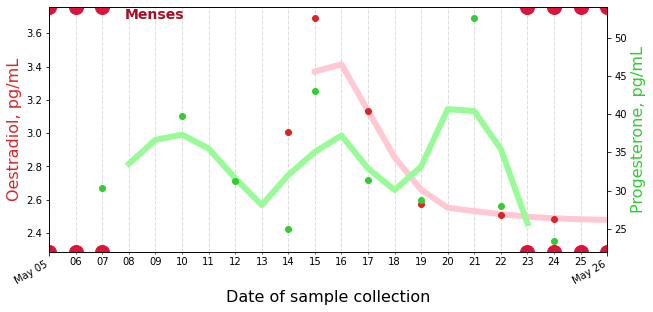

                   rank  total
Heavy legs          1.0  214.0
Concentration loss  2.0  181.0
Mood swings         3.0  133.0
Fatigue             4.0  116.0
Skin problems       5.0   82.0
Food craving        6.0   81.0
Anxiety             7.0   71.0
Paranoia            8.0   52.0
Low mood            9.0   51.0
The number of reported symptoms is: 9


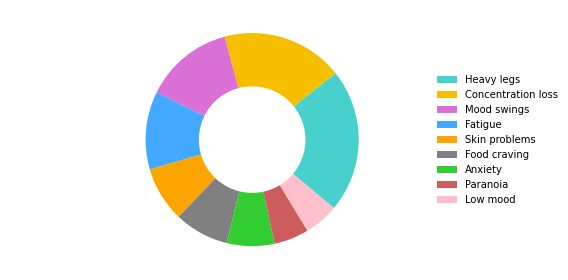

Top recorded symptoms are: ['Heavy legs', 'Concentration loss', 'Mood swings', 'Fatigue']


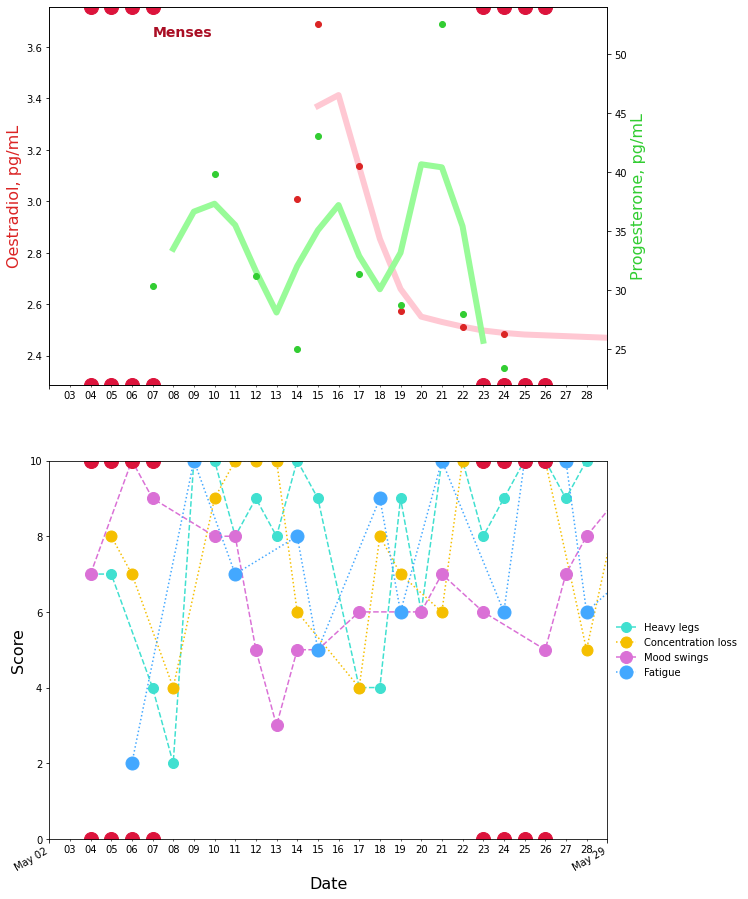

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:902: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['total'] = answers_df.sum(numeric_only=True)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:903: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['rank'] = answers_df.loc['total'].rank(ascending = False)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

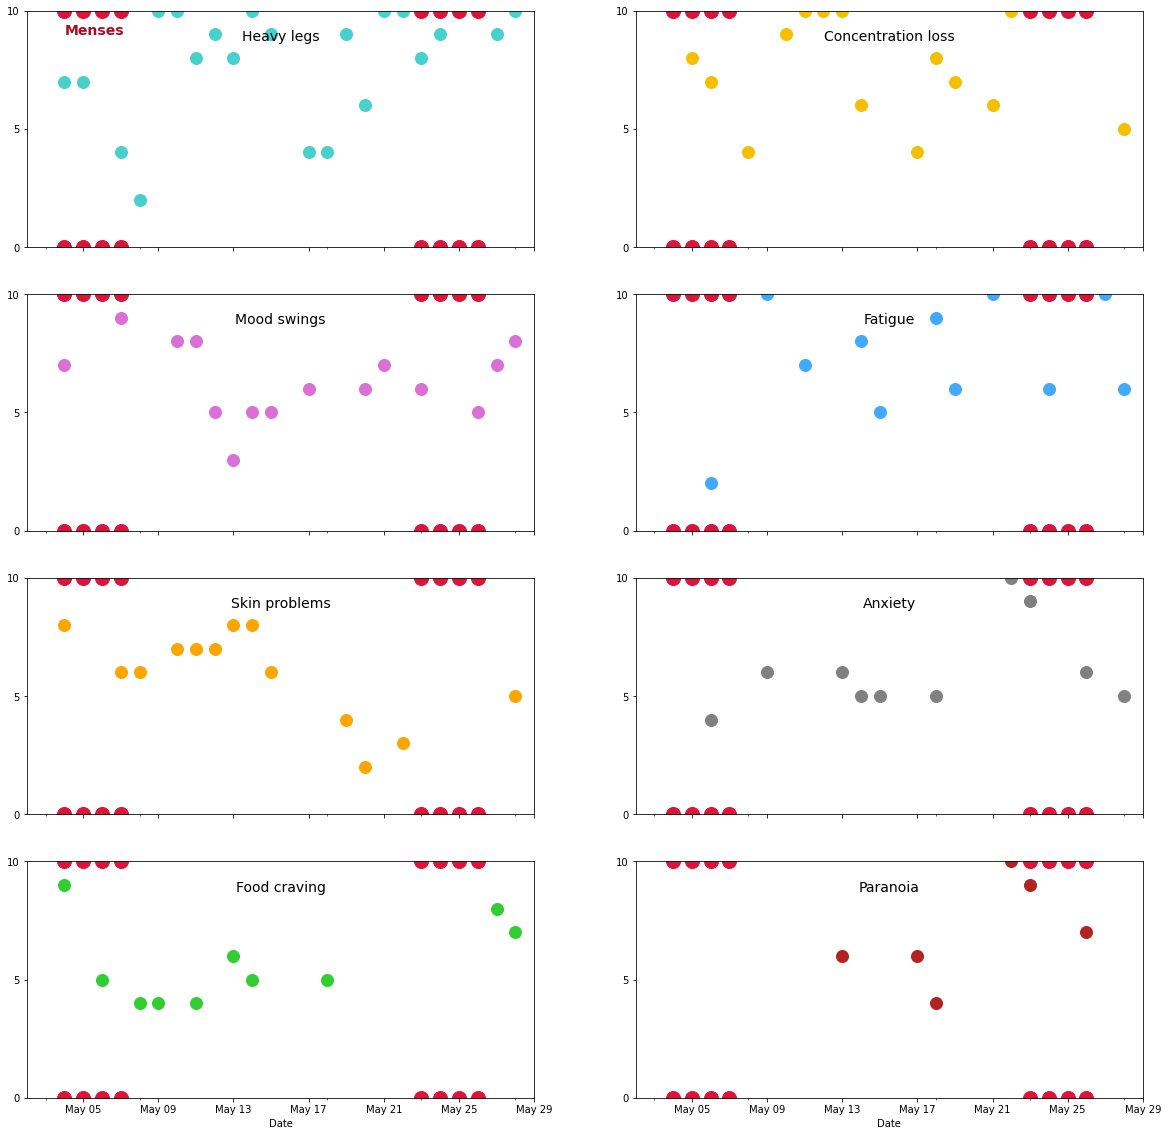

Total number of symptoms is: 19


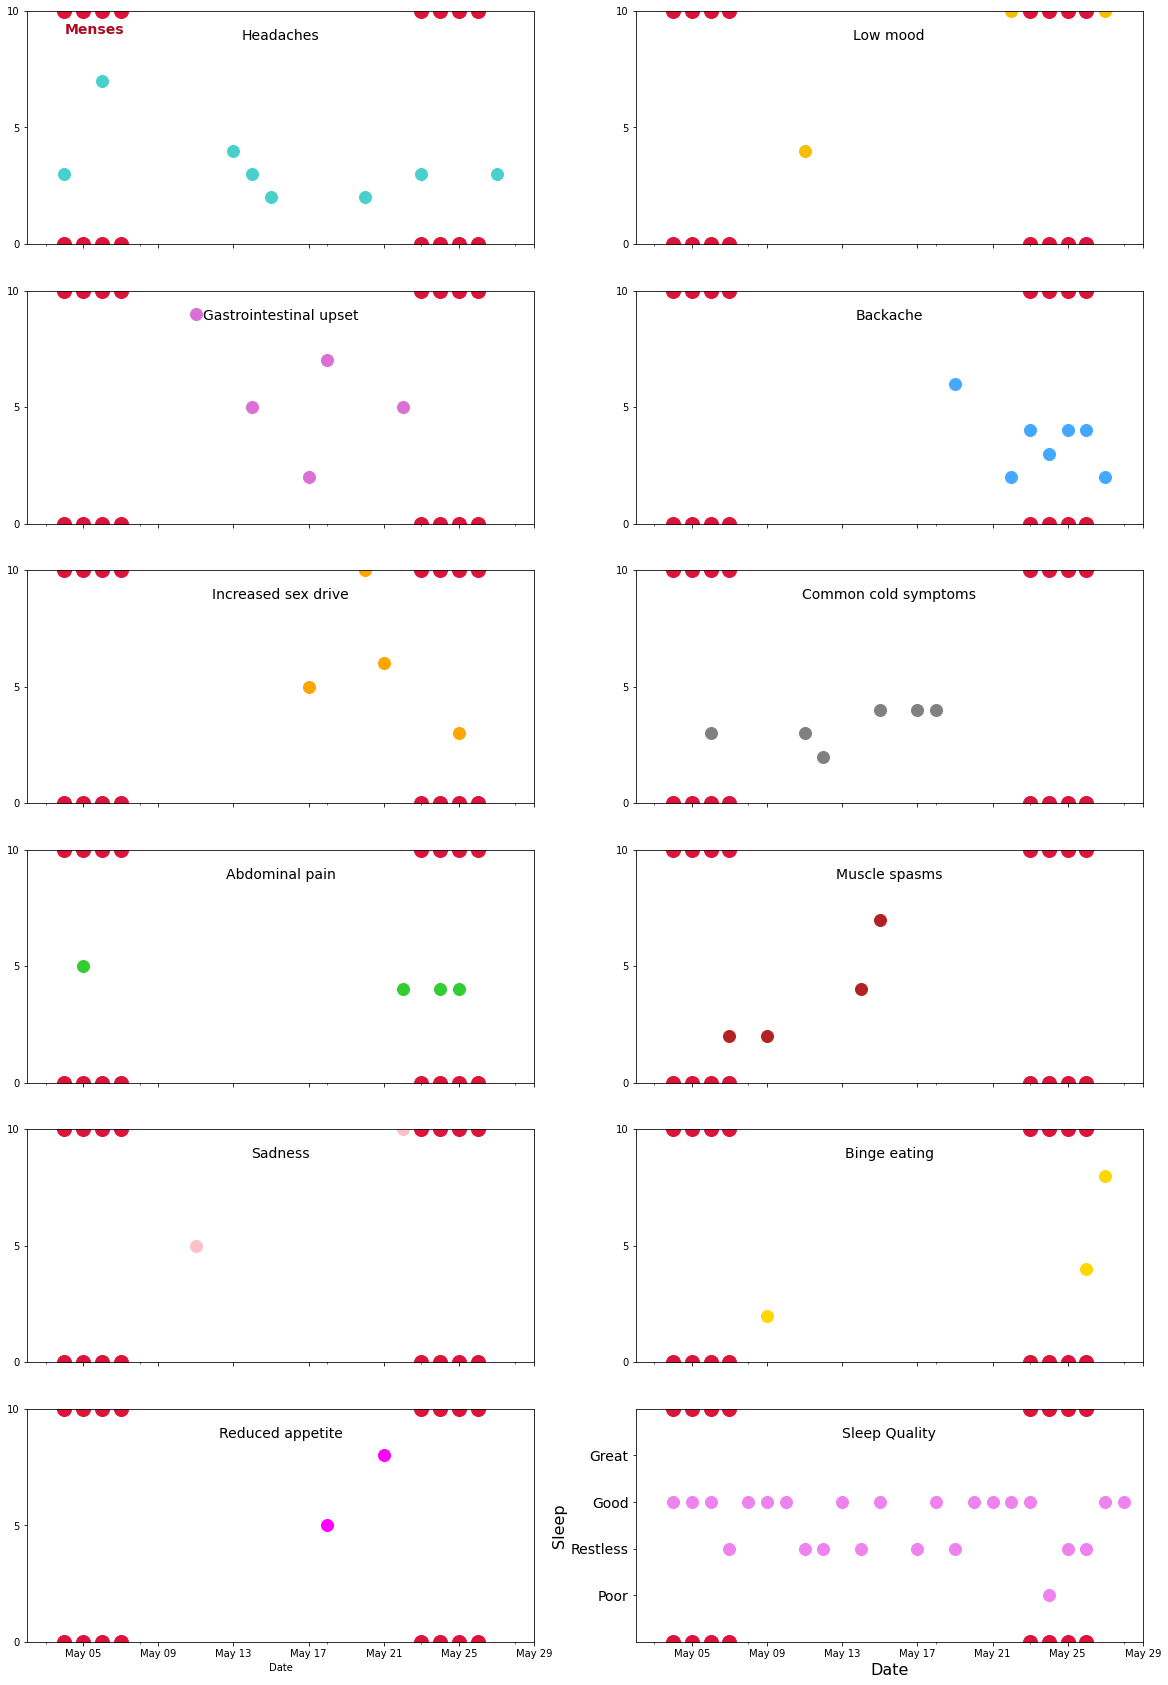

Word document saved. Now converting to PDF...
C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\cc616069-1b43-406b-ba11-393bcd09800d\KIT2


100%|██████████| 1/1 [00:10<00:00, 10.34s/it]
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '15/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '17/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '19/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\7

PDF document saved
Number of samples retrieved: 13
       barcode collectedDate    collectedTime
0   M 005222 D    2022-04-09  06:17:02.527000
1   M 005223 D    2022-04-12  06:38:31.877000
2   M 005224 D    2022-04-13  08:43:10.710000
3   M 005225 D    2022-04-15  08:30:04.787000
4   M 005233 D    2022-04-17  08:15:34.554000
5   M 005230 D    2022-04-19  05:51:08.824000
6   M 005232 D    2022-04-21  07:21:20.489000
7   M 005231 D    2022-04-23  06:18:05.163000
8   M 005228 D    2022-04-26  09:38:20.231000
9   M 005236 D    2022-04-27  10:07:31.175000
10  M 005235 D    2022-04-29  11:34:47.735000
11  M 005226 D    2022-04-30  06:46:17.101000
12  M 005227 D    2022-05-03  07:52:09.477000
Directory already exists: C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\cc616069-1b43-406b-ba11-393bcd09800d\KIT1
Number of estradiol measurements retrieved: 10
2022-03-05 00:00:00 2022-12-04 00:00:00
Number of progesterone measur

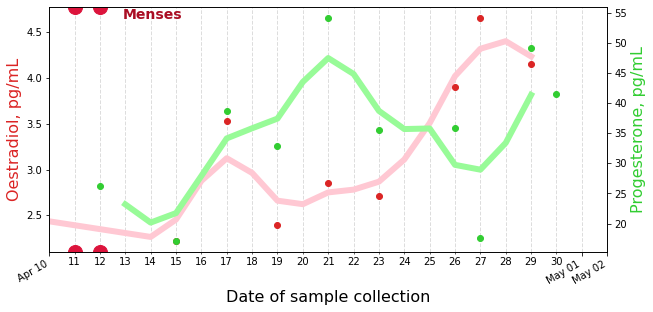

                   rank  total
Heavy legs          1.0  136.0
Anxiety             2.0  118.0
Concentration loss  3.0  102.0
Mood swings         4.0   59.0
Food craving        5.0   45.0
Binge eating        6.0   37.0
Skin problems       7.5   31.0
Sadness             7.5   31.0
Fatigue             9.0   27.0
The number of reported symptoms is: 9


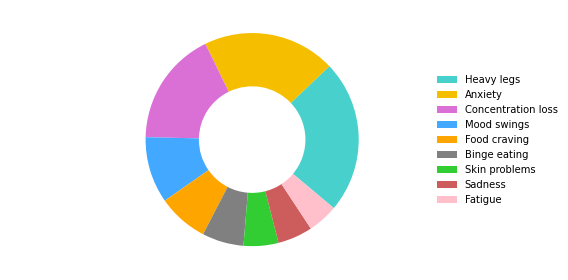

Top recorded symptoms are: ['Heavy legs', 'Anxiety', 'Concentration loss', 'Mood swings']


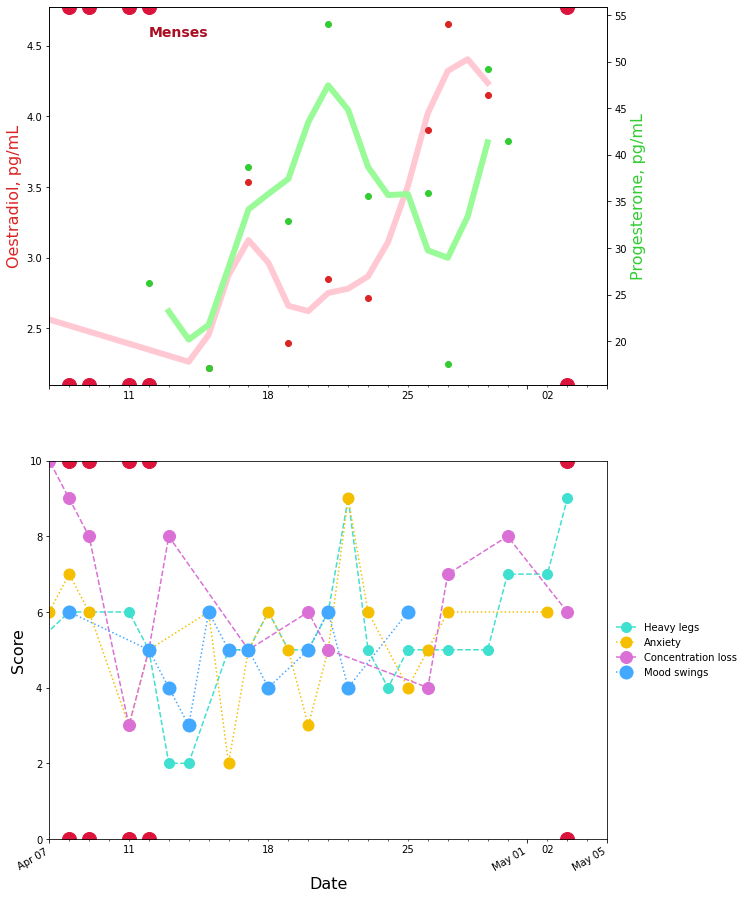

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:902: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['total'] = answers_df.sum(numeric_only=True)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:903: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['rank'] = answers_df.loc['total'].rank(ascending = False)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

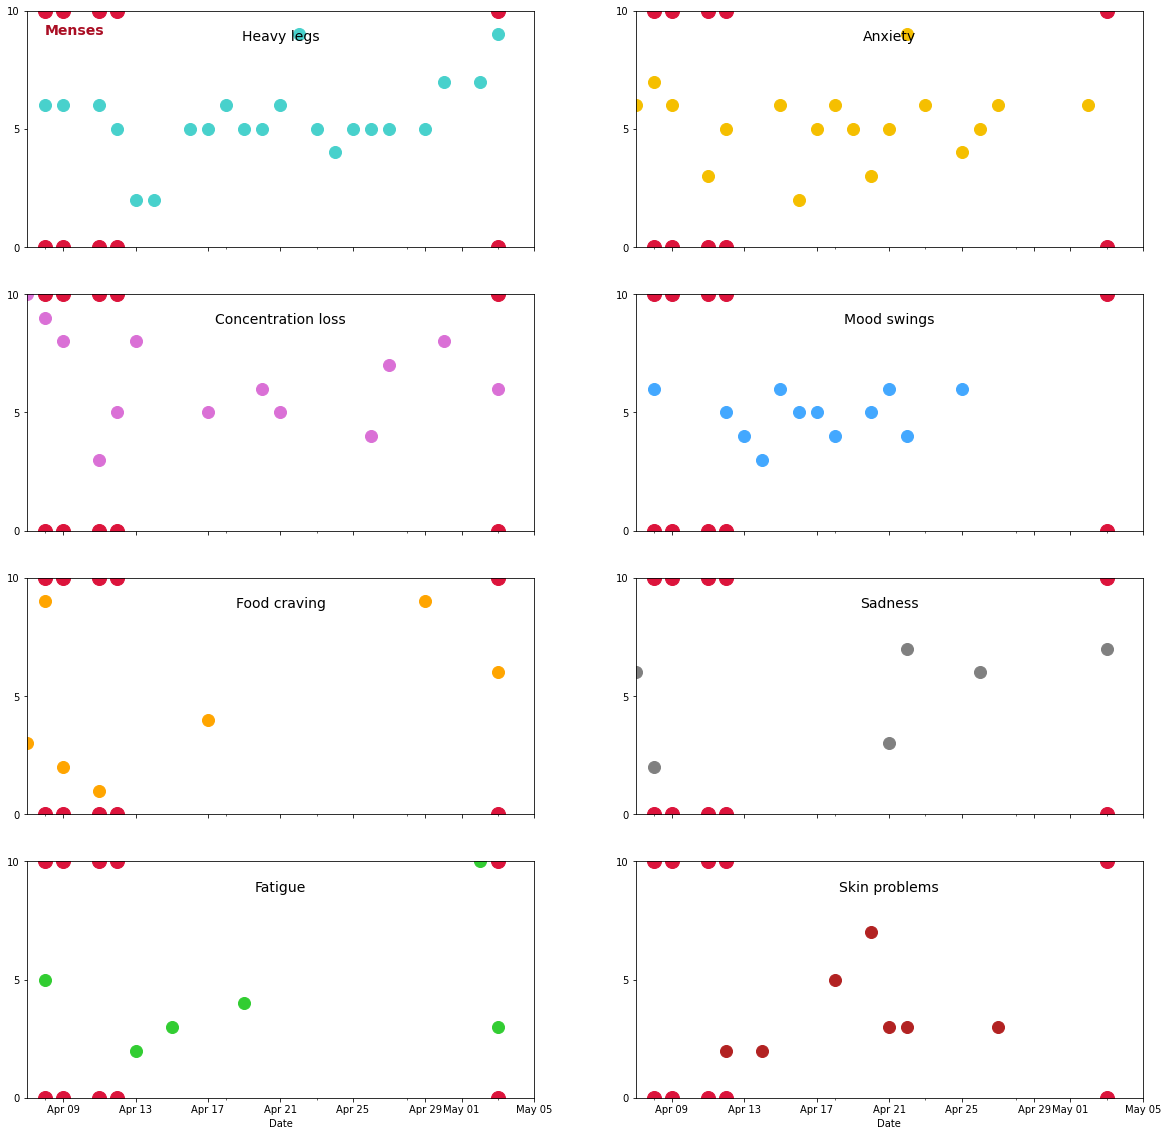

Total number of symptoms is: 19


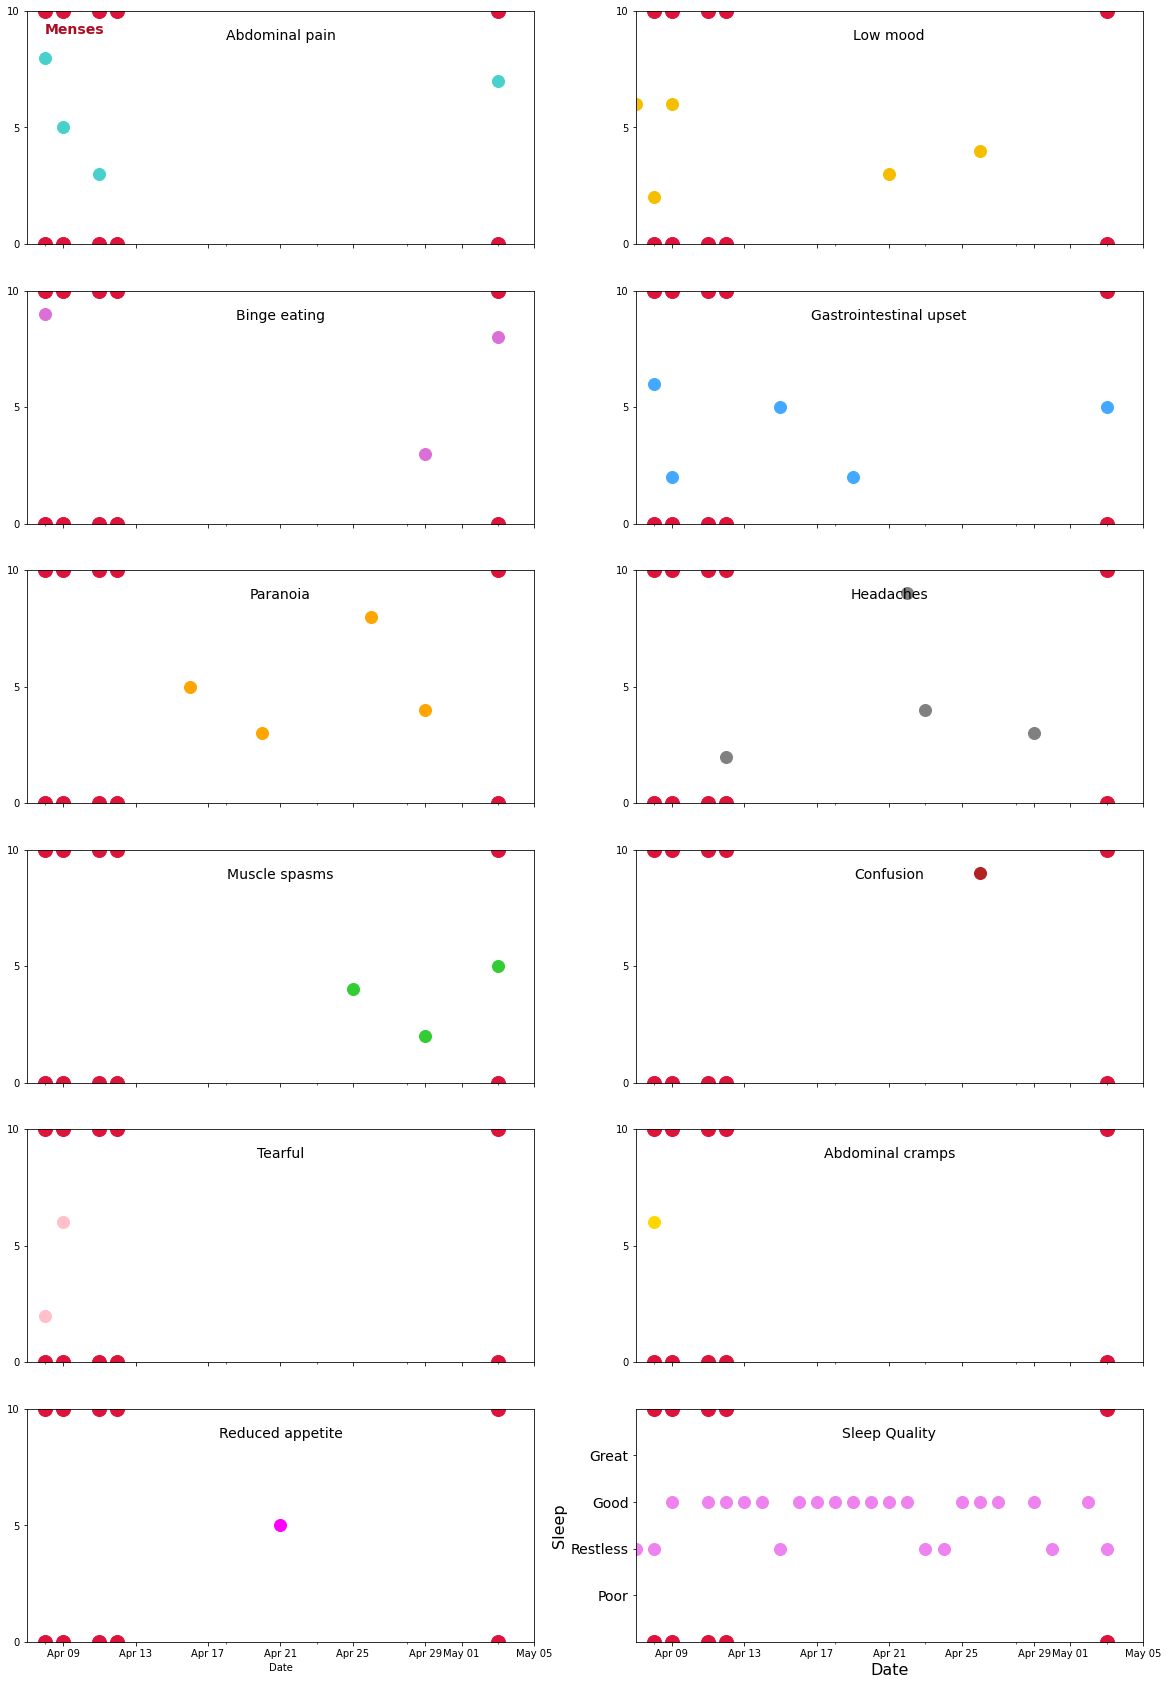

Word document saved. Now converting to PDF...
C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\cc616069-1b43-406b-ba11-393bcd09800d\KIT1


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


PDF document saved
['d4c17c29-86ef-4dfb-b2b6-75d7a3f001af', 'c8a0dfc1-282e-4913-aabd-69c38d5f7d4e'] ['f977ee05-d11b-45b8-9d38-50d69e09ebf2', '5c6e5d03-0761-45e1-b7be-0e812b20699c']
No hormone measurements found for this participant
['d4c17c29-86ef-4dfb-b2b6-75d7a3f001af', 'c8a0dfc1-282e-4913-aabd-69c38d5f7d4e'] ['f977ee05-d11b-45b8-9d38-50d69e09ebf2', '5c6e5d03-0761-45e1-b7be-0e812b20699c']
Found kits: ['1', '2']
Number of samples retrieved: 16
       barcode collectedDate    collectedTime
0   M 005049 D    2022-04-08  08:51:49.831000
1   M 005046 D    2022-04-10  07:49:31.556000
2   M 005052 D    2022-04-11  08:16:40.729000
3   M 005051 D    2022-04-13  07:52:31.040000
4   M 005058 D    2022-04-15  07:04:17.630000
5   M 005059 D    2022-04-17  07:52:10.093000
6   M 005048 D    2022-04-18  07:58:41.885000
7   M 005056 D    2022-04-20  08:27:58.236000
8   M 005053 D    2022-04-22  08:13:09.291000
9   M 005060 D    2022-04-24  06:58:11.578000
10  M 005047 D    2022-04-25  08:44:19.756000

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '18/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '20/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '22/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '24/04/2

Number of progesterone measurements retrieved: 9


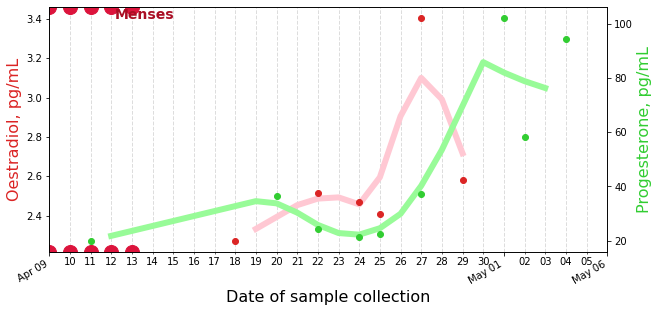

                    rank total
Headaches            1.0  63.0
Food craving         2.0  55.0
Mood swings          3.0  48.0
Heavy legs           4.0  36.0
Fatigue              5.0  22.0
Increased sex drive  6.0  21.0
Concentration loss   7.0  16.0
Low mood             8.0  14.0
Anxiety              9.0  12.0
The number of reported symptoms is: 9


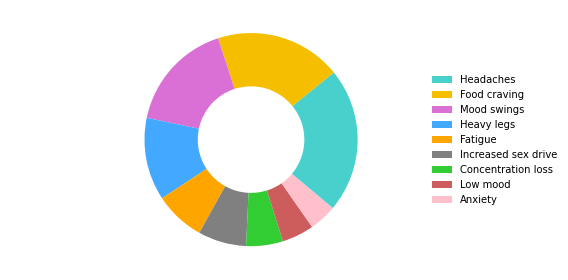

Top recorded symptoms are: ['Headaches', 'Food craving', 'Mood swings', 'Heavy legs']


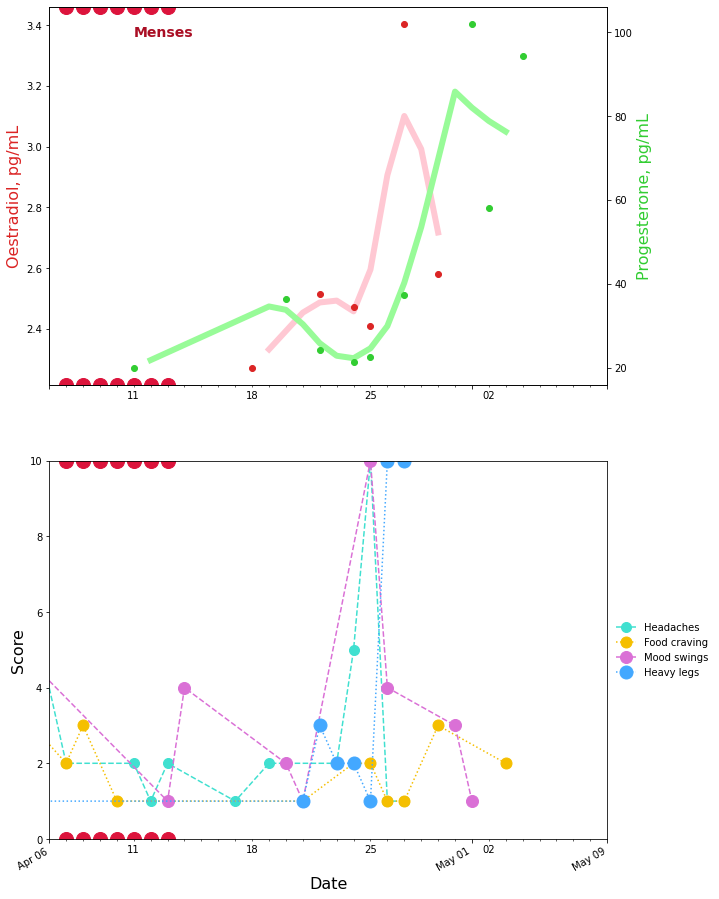

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:902: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['total'] = answers_df.sum(numeric_only=True)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:903: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['rank'] = answers_df.loc['total'].rank(ascending = False)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

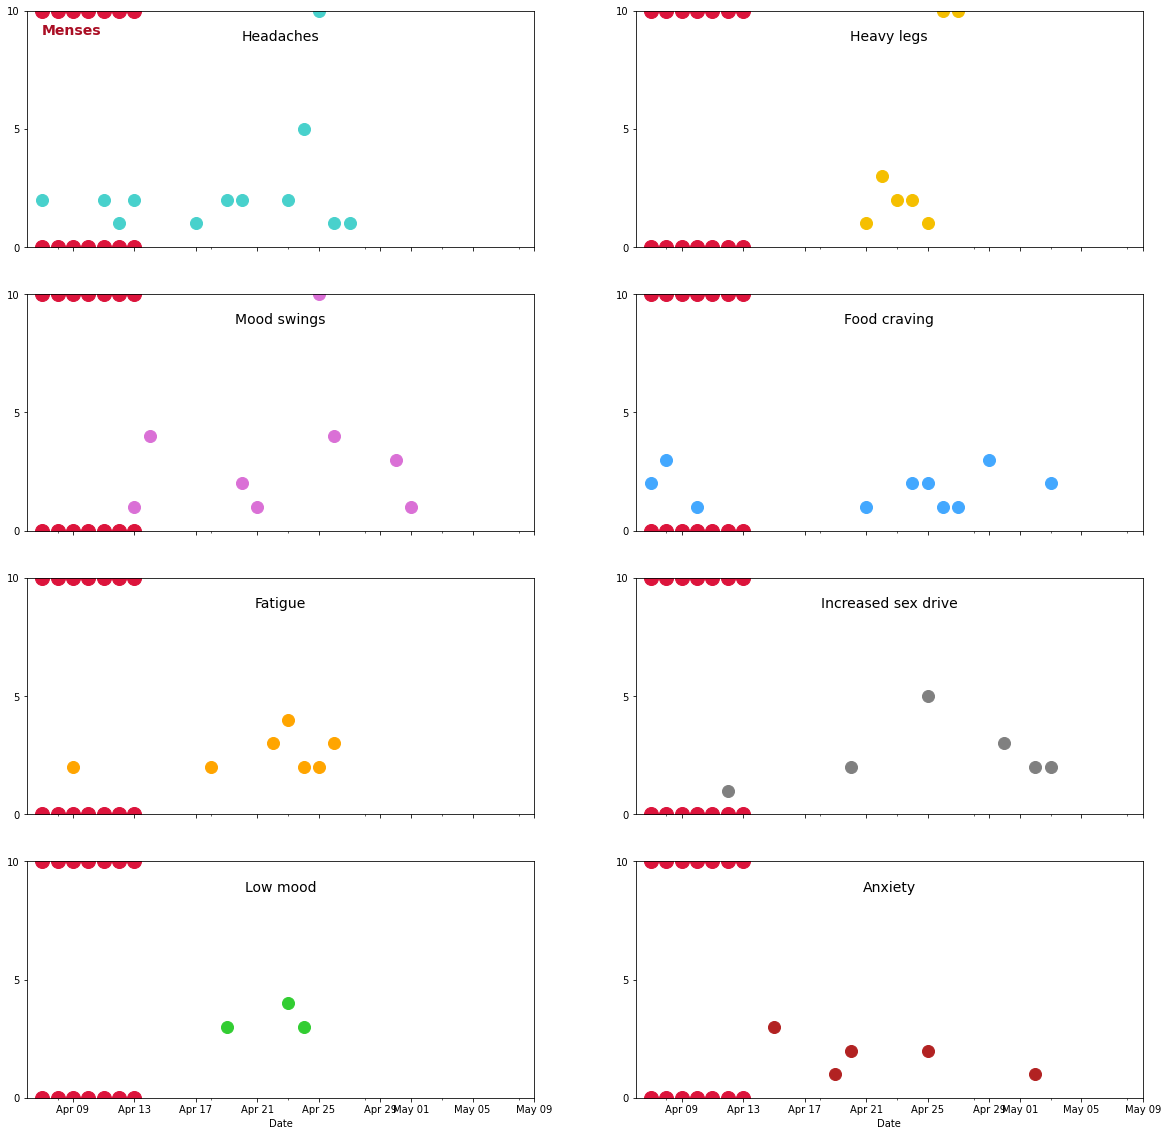

Total number of symptoms is: 10


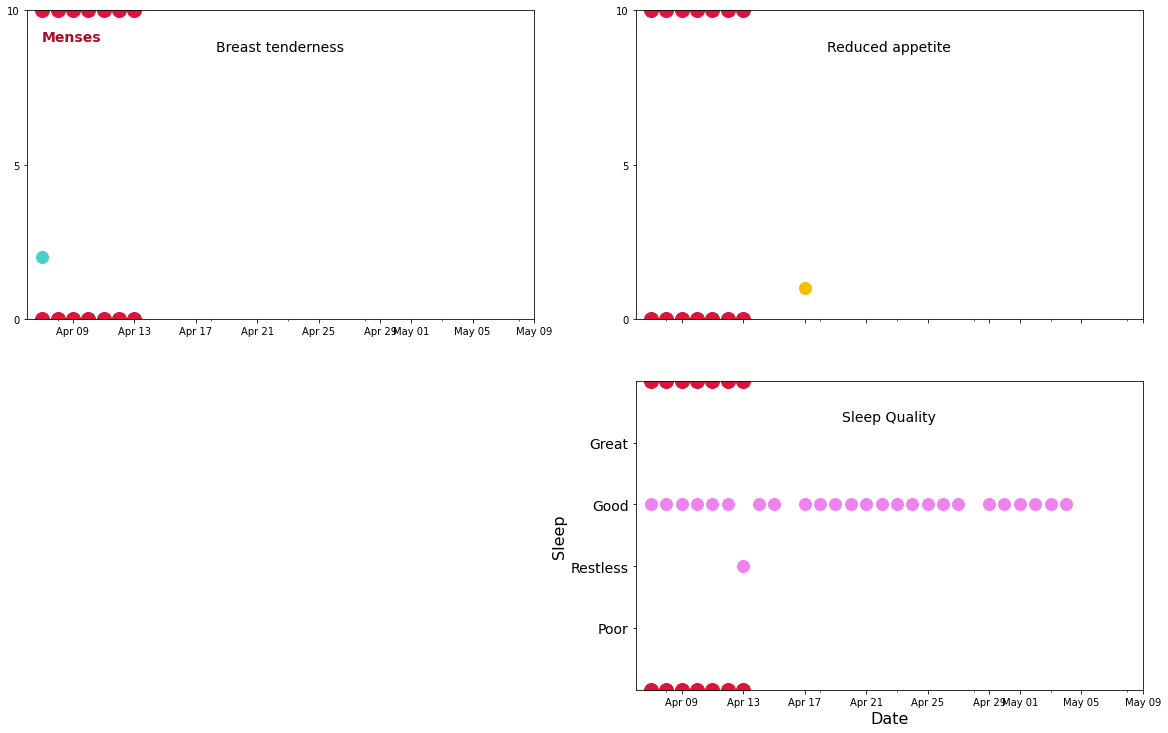

Word document saved. Now converting to PDF...
C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\8cc32ade-185a-414b-891a-e3a1a85ad02d\KIT1


100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


PDF document saved
Number of samples retrieved: 15
       barcode collectedDate    collectedTime
0   M 005240 D    2022-05-13  08:20:26.495000
1   M 005242 D    2022-05-15  08:07:45.671000
2   M 005245 D    2022-05-16  08:12:27.835000
3   M 005252 D    2022-05-18  07:25:56.634000
4   M 005247 D    2022-05-20  07:53:05.455000
5   M 005254 D    2022-05-22  07:43:35.438000
6   M 005246 D    2022-05-23  07:41:25.548000
7   M 005244 D    2022-05-25  08:13:43.138000
8   M 005238 D    2022-05-27  08:15:42.344000
9   M 005241 D    2022-05-29  07:39:19.352000
10  M 005243 D    2022-05-30  08:07:50.884000
11  M 005239 D    2022-06-01  08:29:08.998000
12  M 005249 D    2022-06-03  08:20:03.262000
13  M 005253 D    2022-06-05  04:31:17.143000
14  M 005248 D    2022-06-06  08:13:15.496000
Directory already exists: C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\8cc32ade-185a-414b-891a-e3a1a85ad02d\KIT2
Number of estradiol meas

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '13/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '16/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '20/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '22/05/2

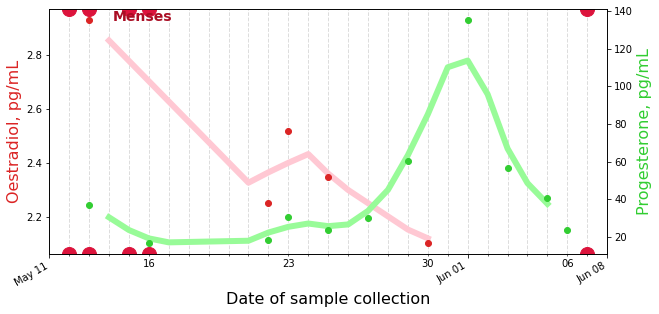

                    rank total
Mood swings          1.0  26.0
Increased sex drive  2.0  21.0
Anxiety              3.0   5.0
Food craving         4.0   4.0
Headaches            5.5   3.0
Paranoia             5.5   3.0
Heavy legs           7.0   1.0
The number of reported symptoms is: 7


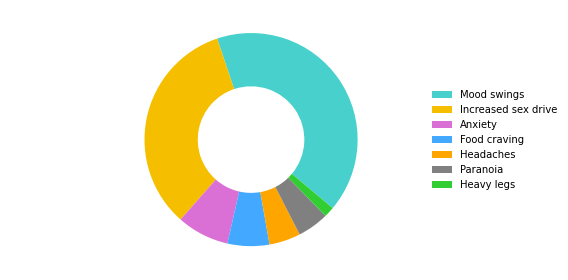

Top recorded symptoms are: ['Mood swings', 'Increased sex drive', 'Anxiety', 'Food craving']


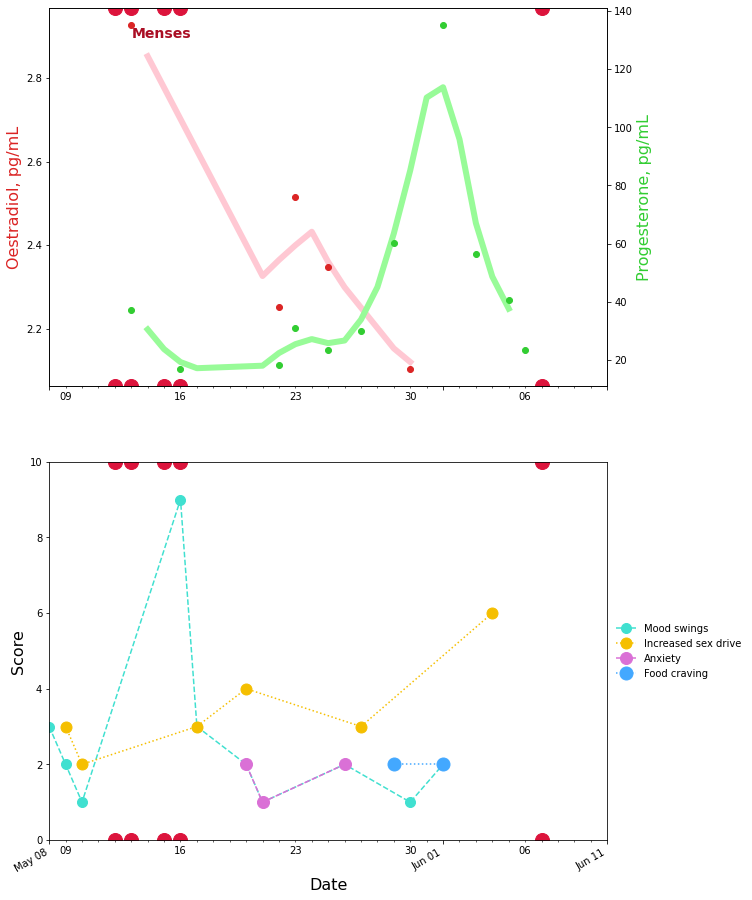

Mood swings 0
Increased sex drive 1
Anxiety 2
Food craving 3
Paranoia 4
Headaches 5
Heavy legs 6


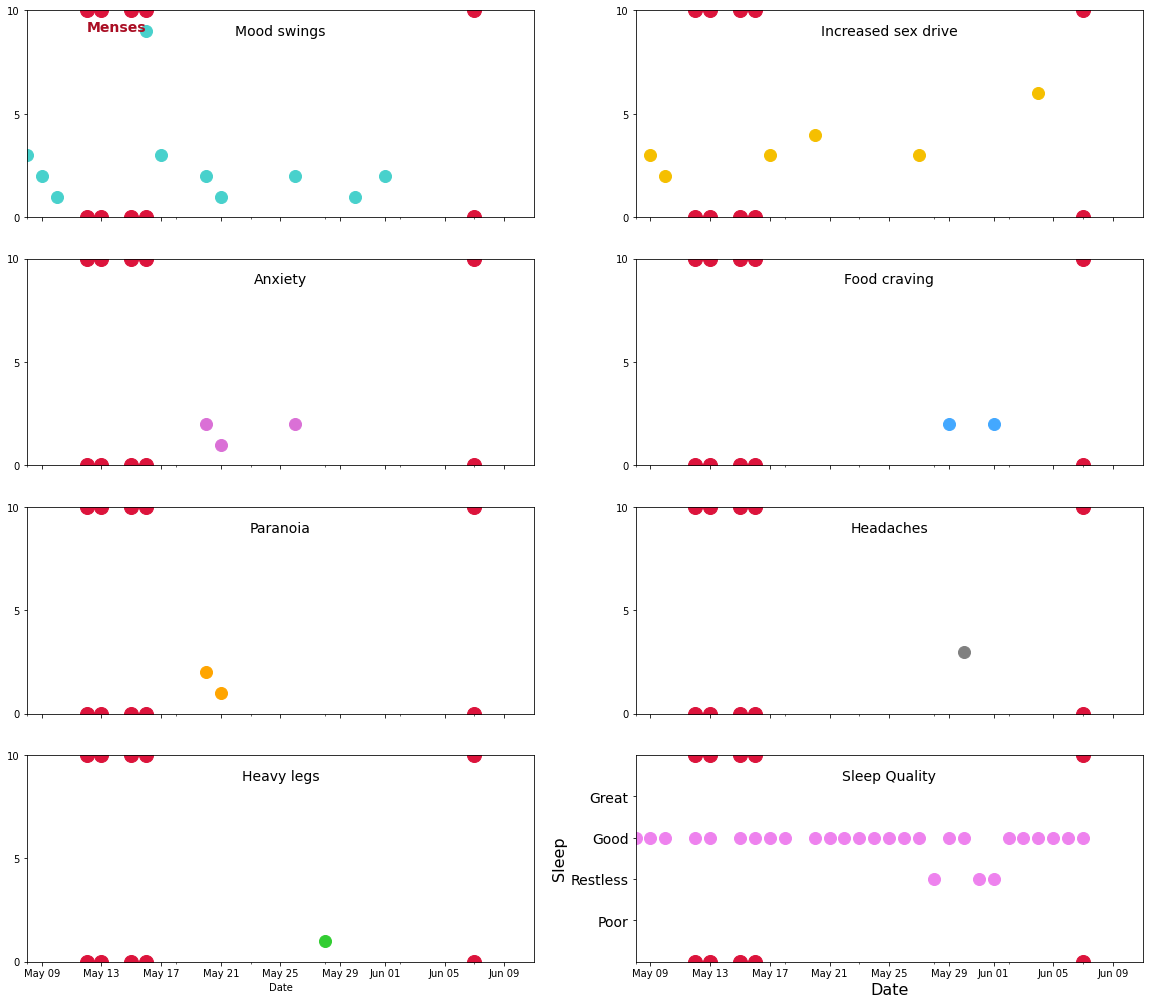

Word document saved. Now converting to PDF...
C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\8cc32ade-185a-414b-891a-e3a1a85ad02d\KIT2


100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


PDF document saved
['d4c17c29-86ef-4dfb-b2b6-75d7a3f001af', 'c8a0dfc1-282e-4913-aabd-69c38d5f7d4e'] ['f977ee05-d11b-45b8-9d38-50d69e09ebf2', '5c6e5d03-0761-45e1-b7be-0e812b20699c']
Found kits: ['1']
Number of samples retrieved: 12
       barcode collectedDate    collectedTime
0   M 005066 D    2022-05-05  04:12:27.983000
1   M 005069 D    2022-05-07  06:09:33.882000
2   M 005077 D    2022-05-09  07:21:56.650000
3   M 005074 D    2022-05-12  06:02:28.023000
4   M 005062 D    2022-05-14  05:17:39.060000
5   M 005070 D    2022-05-16  06:36:27.454000
6   M 005064 D    2022-05-18  05:38:37.029000
7   M 005075 D    2022-05-20  07:08:13.424000
8   M 005076 D    2022-05-22  05:59:49.950000
9   M 005063 D    2022-05-24  05:52:05.371000
10  M 005041 D    2022-07-05  09:14:41.765000
11  M 005043 D    2022-07-12  07:46:28.247000
Directory already exists: C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\dcf792eb-d444-480f-b722-

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '14/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '16/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '18/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '20/05/2

Number of progesterone measurements retrieved: 10


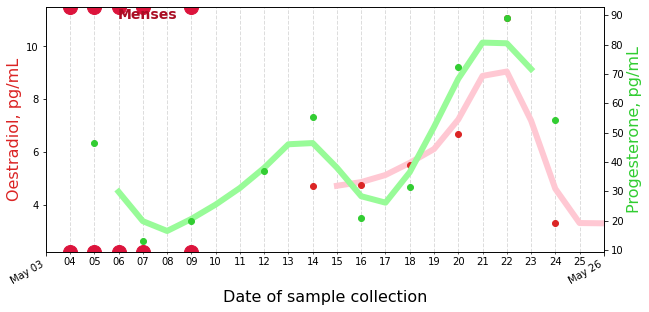

                       rank total
Heavy legs              1.0  25.0
Backache                2.0  15.0
Headaches               3.0  10.0
Muscle spasms           4.0   4.0
Abdominal pain          5.5   2.0
Gastrointestinal upset  5.5   2.0
Joint pain              8.0   1.0
Abdominal cramps        8.0   1.0
Food craving            8.0   1.0
The number of reported symptoms is: 9


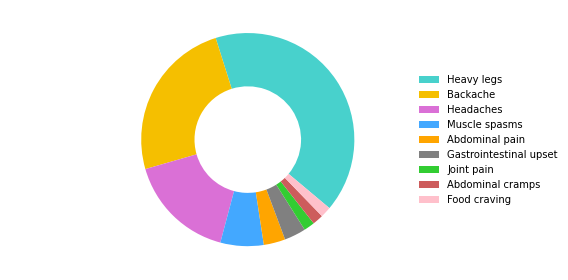

Top recorded symptoms are: ['Heavy legs', 'Backache', 'Headaches', 'Muscle spasms']


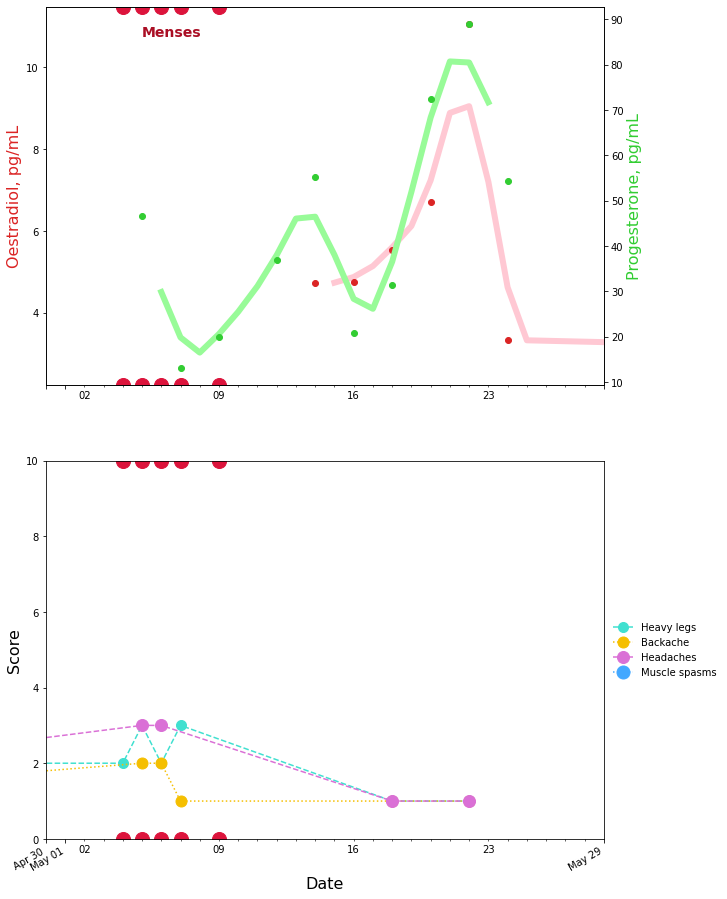

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:902: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['total'] = answers_df.sum(numeric_only=True)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:903: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['rank'] = answers_df.loc['total'].rank(ascending = False)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Heavy legs 0
Headaches 1
Backache 2
Gastrointestinal upset 3
Joint pain 4
Abdominal pain 5
Abdominal cramps 6


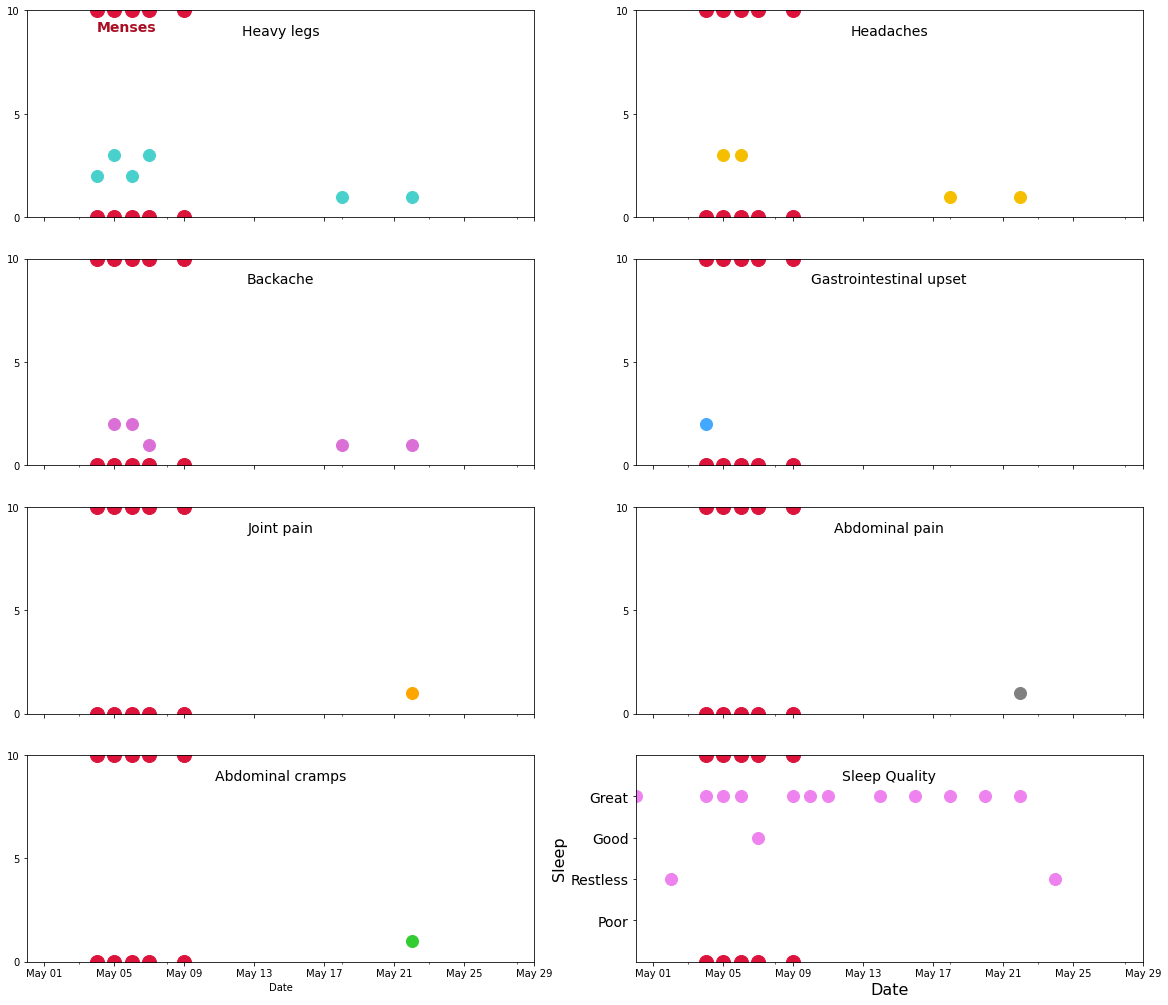

Word document saved. Now converting to PDF...
C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\dcf792eb-d444-480f-b722-1ec4f0e82899\KIT1


100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


PDF document saved
['d4c17c29-86ef-4dfb-b2b6-75d7a3f001af', 'c8a0dfc1-282e-4913-aabd-69c38d5f7d4e'] ['f977ee05-d11b-45b8-9d38-50d69e09ebf2', '5c6e5d03-0761-45e1-b7be-0e812b20699c']
Found kits: ['2', '1']
Number of samples retrieved: 8
      barcode collectedDate    collectedTime
0  M 005269 D    2022-05-21  06:45:42.169000
1  M 005258 D    2022-05-23  06:19:48.981000
2  M 005261 D    2022-05-25  08:28:02.177000
3  M 005268 D    2022-05-29  07:26:07.072000
4  M 005260 D    2022-06-01  07:52:54.817000
5  M 005267 D    2022-06-03  07:52:57.792000
6  M 005259 D    2022-06-04  17:37:02.145000
7  M 005262 D    2022-06-08  08:02:04.996000
Directory already exists: C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\f78d620b-c8a3-4bf8-8848-defb7a6a6d28\KIT2
Number of estradiol measurements retrieved: 8
2022-01-06 00:00:00 2022-08-06 00:00:00


C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '21/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '23/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '25/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '29/05/2

Number of progesterone measurements retrieved: 8


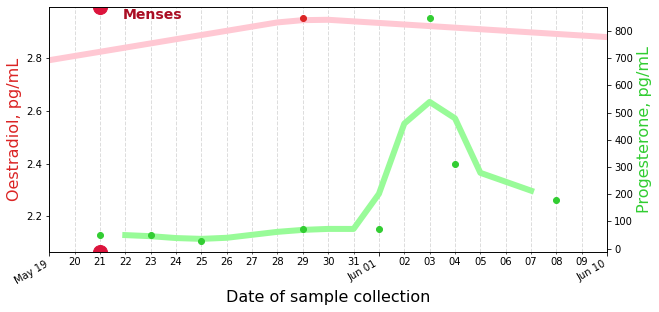

                       rank total
Headaches               1.0  14.0
Concentration loss      2.0  10.0
Low mood                3.0   6.0
Abdominal pain          5.5   5.0
Abdominal cramps        5.5   5.0
Heavy legs              5.5   5.0
Gastrointestinal upset  5.5   5.0
Fatigue                 8.0   4.0
Food craving            9.0   3.0
The number of reported symptoms is: 9


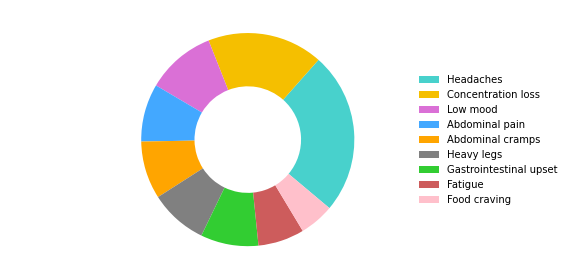

Top recorded symptoms are: ['Headaches', 'Concentration loss', 'Low mood', 'Abdominal pain']


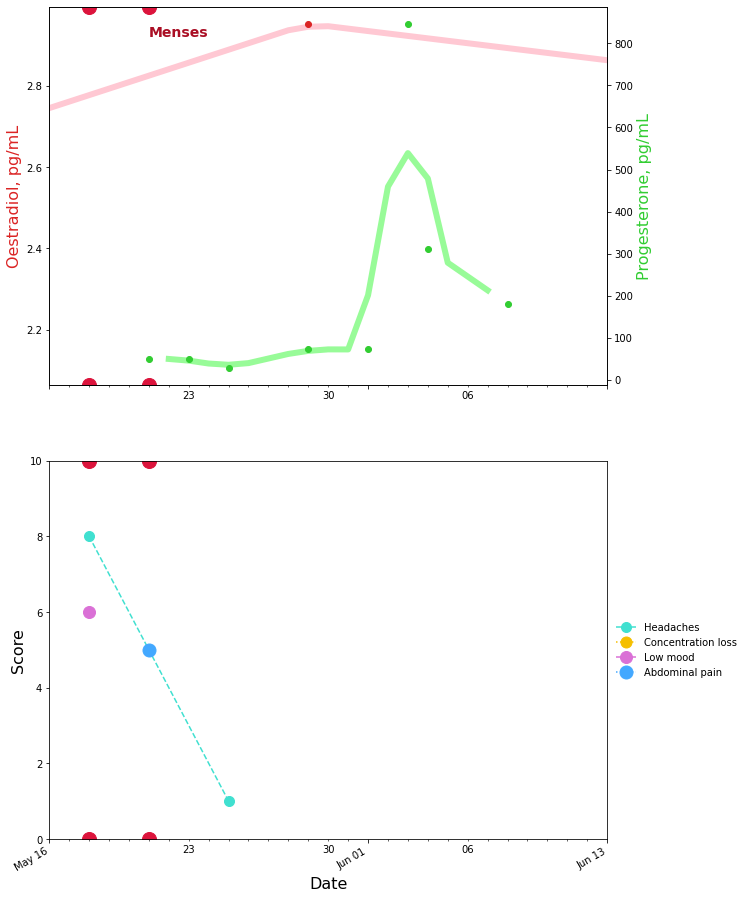

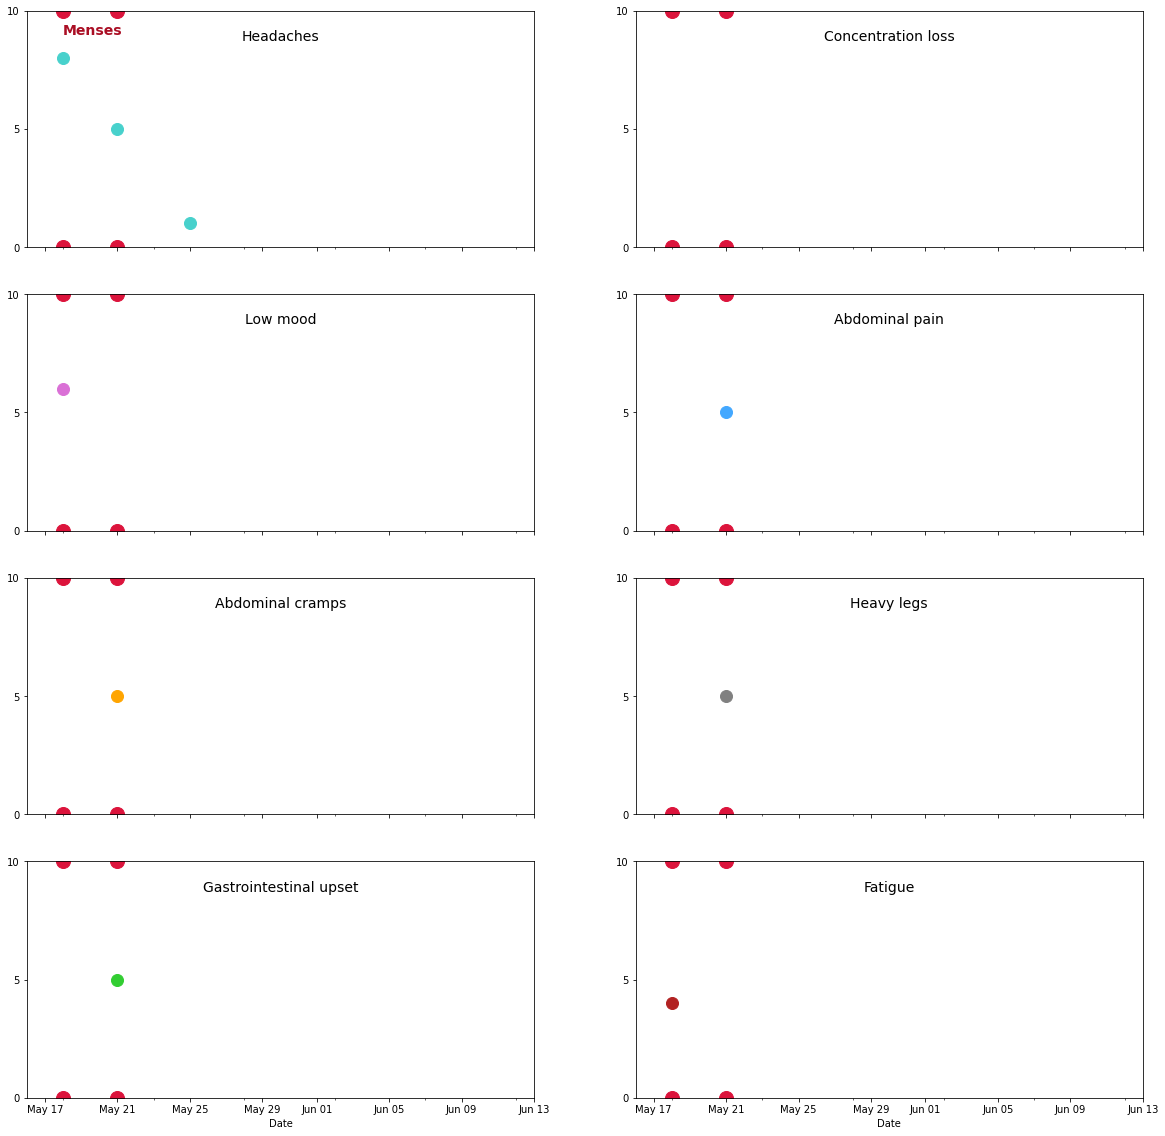

Total number of symptoms is: 10


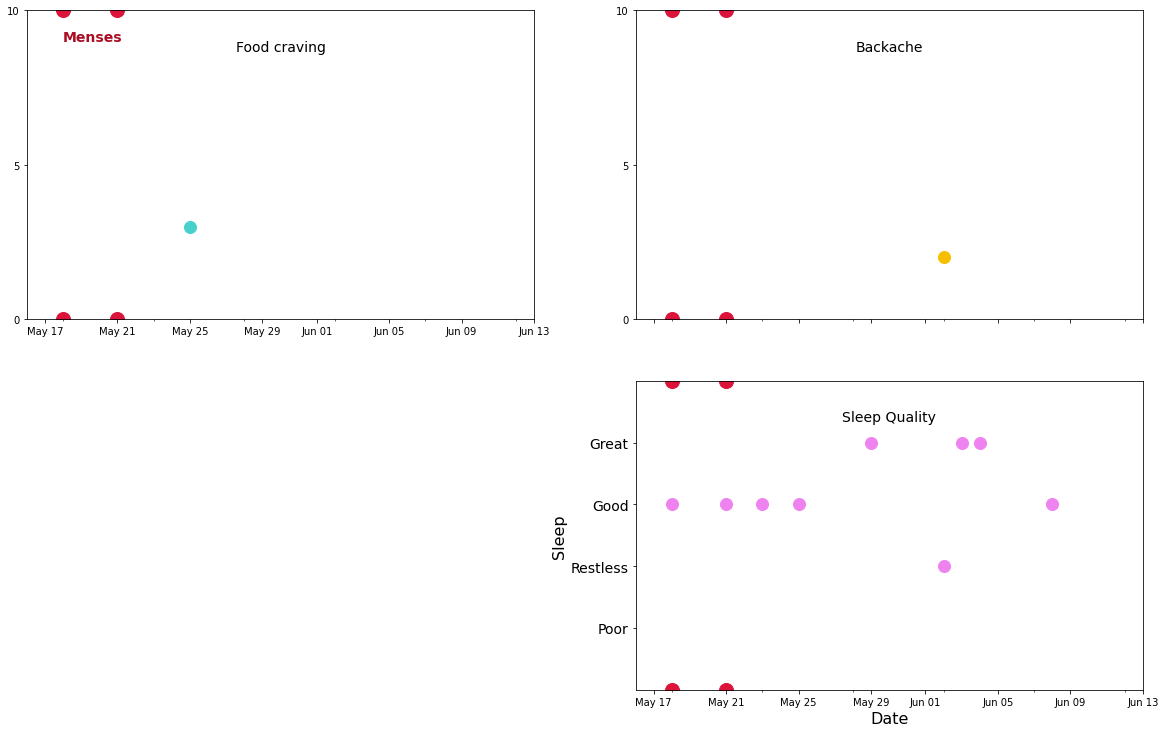

Word document saved. Now converting to PDF...
C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\f78d620b-c8a3-4bf8-8848-defb7a6a6d28\KIT2


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '14/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '20/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:361: UserWarning: Parsing '22/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  e_df['collectedDate'] = pd.to_datetime(e_df['collectedDate'].dt.strftime('%d/%m/%Y'))
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\7

PDF document saved
Number of samples retrieved: 16
       barcode collectedDate    collectedTime
0   M 005221 D    2022-04-12  06:54:23.810000
1   M 005214 D    2022-04-13  07:12:49.169000
2   M 005209 D    2022-04-14  06:12:00.953000
3   M 005212 D    2022-04-19  21:23:11.994000
4   M 005216 D    2022-04-20  08:16:30.474000
5   M 005217 D    2022-04-22  06:47:19.492000
6   M 005211 D    2022-04-24  07:11:17.752000
7   M 005206 D    2022-04-26  07:06:06.998000
8   M 005219 D    2022-04-27  07:06:37.906000
9   M 005208 D    2022-04-29  07:07:54.876000
10  M 005220 D    2022-05-01  07:11:00.538000
11  M 005213 D    2022-05-03  06:48:09.446000
12  M 005207 D    2022-05-04  06:46:54.734000
13  M 005218 D    2022-05-06  15:32:35.968000
14  M 005210 D    2022-05-08  06:51:34.605000
15  M 005256 D    2022-05-17  11:36:15.455000
Directory already exists: C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\f78d620b-c8a3-4bf8-8

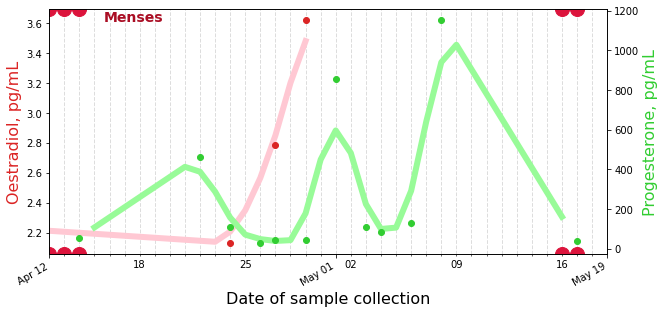

                    rank total
Heavy legs           1.0  51.0
Concentration loss   2.0  35.0
Fatigue              3.0  31.0
Abdominal pain       4.5  28.0
Food craving         4.5  28.0
Abdominal cramps     6.0  26.0
Headaches            7.0  20.0
Backache             8.0  10.0
Increased sex drive  9.0   6.0
The number of reported symptoms is: 9


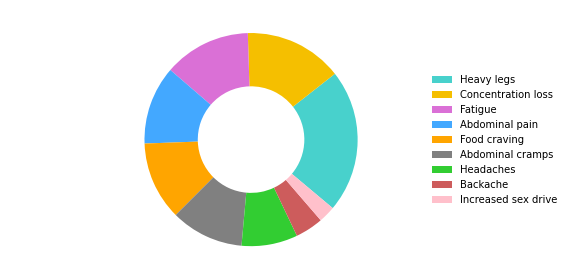

Top recorded symptoms are: ['Heavy legs', 'Concentration loss', 'Fatigue', 'Abdominal pain']


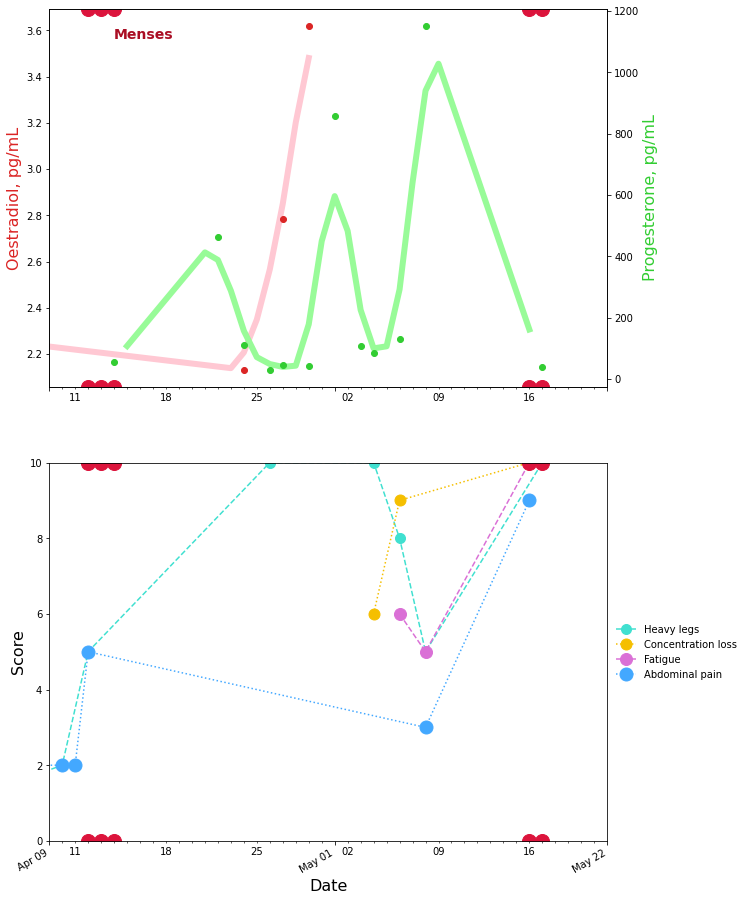

C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:902: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['total'] = answers_df.sum(numeric_only=True)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:903: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df.loc['rank'] = answers_df.loc['total'].rank(ascending = False)
C:\Users\KatherineRidley\AppData\Local\Temp\ipykernel_4376\751733413.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

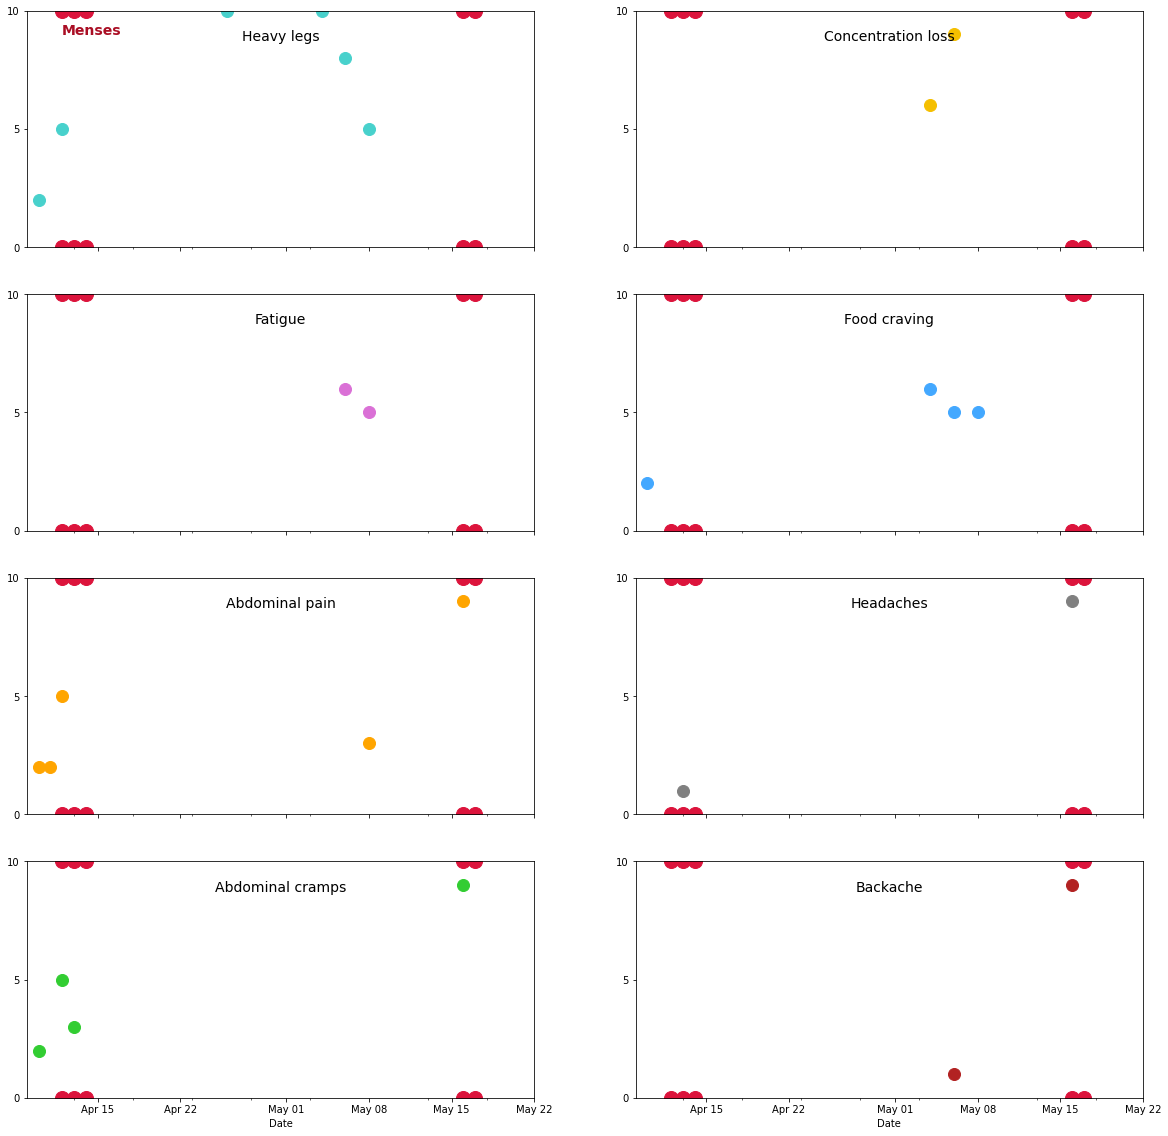

Total number of symptoms is: 12


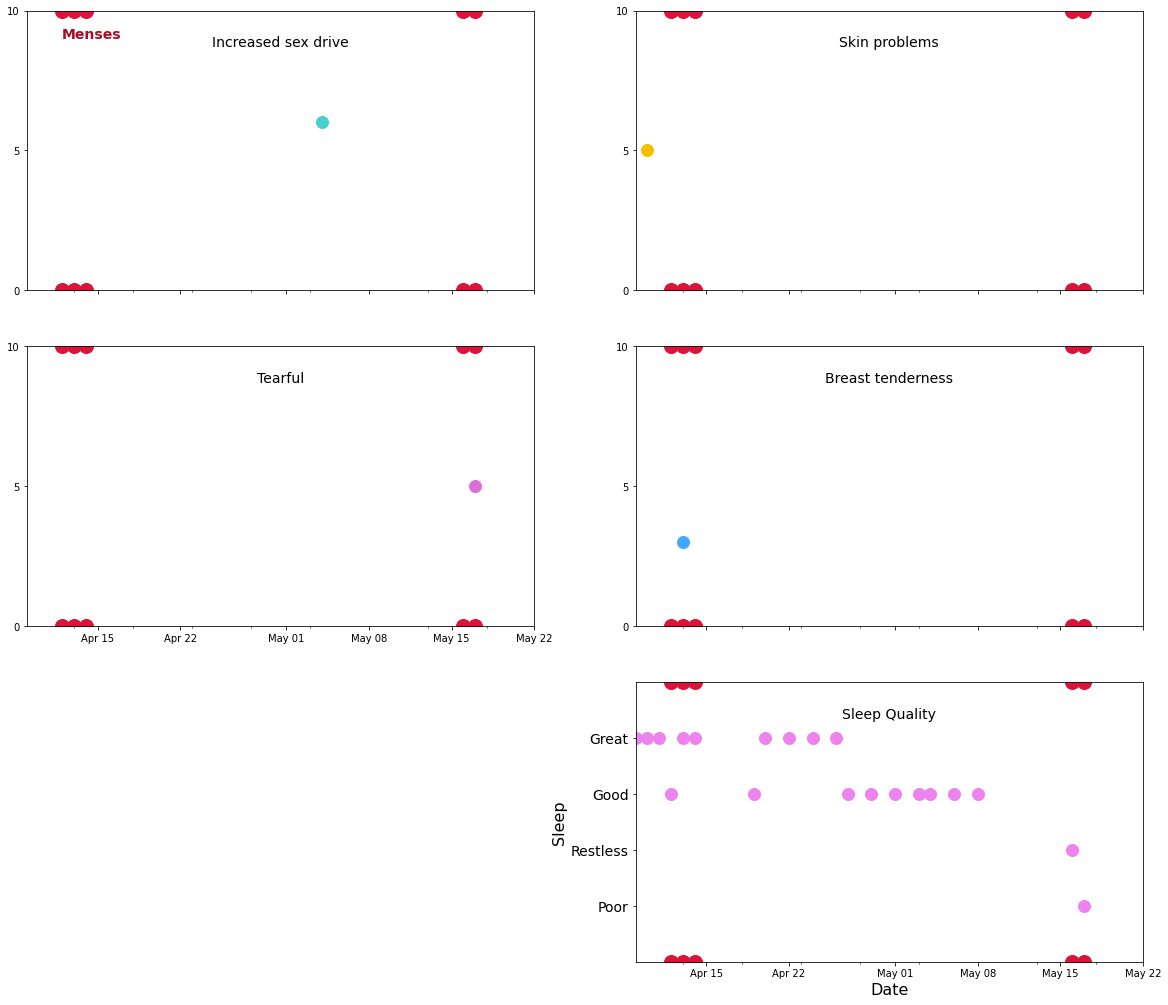

Word document saved. Now converting to PDF...
C:/Users/KatherineRidley/Mint Diagnostics Ltd/Hormone Data Analysis - General/Athlete Data Reports/Data Reports (KR)\VNZ\f78d620b-c8a3-4bf8-8848-defb7a6a6d28\KIT1


100%|██████████| 1/1 [00:07<00:00,  7.40s/it]


PDF document saved
['d4c17c29-86ef-4dfb-b2b6-75d7a3f001af', 'c8a0dfc1-282e-4913-aabd-69c38d5f7d4e'] ['f977ee05-d11b-45b8-9d38-50d69e09ebf2', '5c6e5d03-0761-45e1-b7be-0e812b20699c']
No hormone measurements found for this participant


In [29]:

connect_dynamodb('eu-west-2','default')
org_df_meta=dynamo_pandas.get_df(table='Organisation-qx7lirnxjfdzxoss6cmomxzgpe-staging')
print('Please input organisation name from this list: ')    
print(org_df_meta.name)
org_code_gcr=get_org_from_dynamo('Organisation-qx7lirnxjfdzxoss6cmomxzgpe-staging')
org_code=org_code_gcr[:-4]
print('...')
inTitles = False
while inTitles == False:
    print('Do you want to choose a programme from this organisation? (y/n)')
    prog_yn = input('Do you want to choose a programme? (y/n): ')
    if (prog_yn == 'y') | (prog_yn == 'Y'):
        inTitles=True
        prog_id= get_prog_from_org(org_code_gcr)
        print('...')
        par_id= get_participants_from_study(prog_id, org_code_gcr)
        #batch_yn = input('Do you want to generate a batch report for all particpants in this programme? (y/n): ')
    elif (prog_yn == 'n') | (prog_yn == 'N'):
        par_id =get_participants_from_org(org_code_gcr)
        inTitles =True

for par in par_id:
    estradiol_tbc_id,progesterone_tbc_id = get_test_batch_codes('TestBatchCode-qx7lirnxjfdzxoss6cmomxzgpe-staging')
    print(estradiol_tbc_id, progesterone_tbc_id)
    #mostrecentkitdf= getmostrecentkit(par)
    #kitnum=mostrecentkitdf.loc[mostrecentkitdf['measurementAthleteId']==par, 'kit'].iloc[0]
    #print('Most recent kit is:', kitnum)
    kitlist=getallkitnums(par)
    if len(kitlist)>0:
        
        for kitnum in kitlist:
        
            samples_df=get_samples(par, kitnum)
            print(samples_df)
            export_path=make_dirs(org_code_gcr, kitnum, par, directory)
            e_df, p_df = get_e_df_and_p_df(kitnum, par, estradiol_tbc_id,progesterone_tbc_id)
            
            answers_df=get_answers(par, kitnum)
            ep_chart=get_figure(answers_df, e_df, p_df, export_path)
            if len(answers_df)==0:
                get_pdf_no_symptoms(samples_df, e_df, p_df, par, export_path)
            else:
                symp_df, symplen = get_symptom_df(answers_df)
                print('The number of reported symptoms is:', symplen)
                if symplen>0:
                    symptomdonut= get_symptom_donut(symp_df, export_path)
                    symptomchart= get_symptom_chart(answers_df, symp_df, export_path)
                    combined, answers_df= combined_chart(answers_df, symp_df,export_path, e_df, p_df)
                    symp_df=symptom_chart_expanded(answers_df, export_path, ep_chart, p_df)
                    symplen=len(symp_df)
                    get_pdf(samples_df, e_df, p_df, par, export_path, symplen)
                    #sleep_chart(answers_df, export_path)
                else:
                    print('No symptoms reported')
                    get_pdf_no_symptoms(samples_df, e_df, p_df, par, export_path)

    #sleep_chart(answers_df, export_path)
    




